In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import product

In [5]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
processed_DPW_path = os.path.join(project_root, 'data', 'processed', 'Pittsburgh_DPW_final.csv')
DPW_df = pd.read_csv(processed_DPW_path)

DPW_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40472 entries, 0 to 40471
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   40472 non-null  int64  
 1   status_name           40472 non-null  object 
 2   dept                  40472 non-null  object 
 3   request_type_name     40472 non-null  object 
 4   create_date_et        40472 non-null  object 
 5   closed_date_et        38472 non-null  object 
 6   origin                40472 non-null  object 
 7   neighborhood          39970 non-null  object 
 8   resolution_time_days  38472 non-null  float64
 9   hour                  40472 non-null  int64  
 10  day_of_week           40472 non-null  int64  
 11  month                 40472 non-null  int64  
 12  is_weekend            40472 non-null  int64  
 13  week_of_year          40472 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 4.3+ MB


In [6]:
weather_path = os.path.join(project_root, 'data', 'processed', 'weather_data.csv')
weather_df = pd.read_csv(weather_path)

weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1212 non-null   object 
 1   NAME     1212 non-null   object 
 2   DATE     1212 non-null   object 
 3   AWND     1209 non-null   float64
 4   PRCP     1211 non-null   float64
 5   SNOW     1210 non-null   float64
 6   SNWD     1211 non-null   float64
 7   TAVG     1212 non-null   int64  
 8   TMAX     1211 non-null   float64
 9   TMIN     1211 non-null   float64
 10  WDF2     1209 non-null   float64
 11  WDF5     1209 non-null   float64
 12  WSF2     1209 non-null   float64
 13  WSF5     1209 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 132.7+ KB


In [7]:
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
DPW_df['create_date_et'] = pd.to_datetime(DPW_df['create_date_et'])

DPW_df['create_date_et_DATE'] = DPW_df['create_date_et'].dt.date
weather_df['DATE'] = weather_df['DATE'].dt.date


In [8]:
### Merge weather data with DPW data on date, and add weather features to DPW data (left join on DPW data create_date_et)
merged_df = pd.merge(DPW_df, weather_df, left_on='create_date_et_DATE', right_on='DATE', how='left')
merged_df.info()
merged_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40472 entries, 0 to 40471
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   _id                   40472 non-null  int64         
 1   status_name           40472 non-null  object        
 2   dept                  40472 non-null  object        
 3   request_type_name     40472 non-null  object        
 4   create_date_et        40472 non-null  datetime64[ns]
 5   closed_date_et        38472 non-null  object        
 6   origin                40472 non-null  object        
 7   neighborhood          39970 non-null  object        
 8   resolution_time_days  38472 non-null  float64       
 9   hour                  40472 non-null  int64         
 10  day_of_week           40472 non-null  int64         
 11  month                 40472 non-null  int64         
 12  is_weekend            40472 non-null  int64         
 13  week_of_year    

,_id,status_name,dept,request_type_name,create_date_et,closed_date_et,origin,neighborhood,resolution_time_days,hour,...,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,65,in progress,DPW - Street Maintenance,"Litter, Public Property",2023-07-08 11:38:00,NaN,Website,NaN,NaN,11,...,0.00,0.0,0.0,72,82.0,61.0,160.0,190.0,13.0,18.1
1,86,closed,DPW - Street Maintenance,Trail Maintenance,2024-08-28 08:23:00,2024-12-26 12:45:00,Call Center,NaN,120.181944,8,...,0.00,0.0,0.0,82,93.0,72.0,360.0,290.0,13.0,19.9
2,177,closed,DPW - Street Maintenance,Street Cleaning/Sweeping,2024-09-05 09:41:00,2024-09-27 06:35:00,Call Center,NaN,21.870833,9,...,0.00,0.0,0.0,68,82.0,54.0,110.0,100.0,10.1,13.0
3,454,closed,DPW - Street Maintenance,Trail Maintenance,2024-08-06 11:35:00,2024-12-26 12:51:00,Call Center,NaN,142.052778,11,...,0.81,0.0,0.0,79,91.0,69.0,350.0,360.0,29.1,36.0
4,669,open,DPW - Street Maintenance,"Litter, Public Property",2023-05-22 10:12:00,NaN,Website,NaN,NaN,10,...,0.00,0.0,0.0,62,76.0,46.0,310.0,310.0,12.1,14.1


### Modeling Pipeline: Weekly 311 Request Forecast

---

#### 1. Feature Engineering

**A. Aggregate to Weekly Level**
- Group raw data by `(week_start, neighborhood, request_type_name)`
- Count requests → `request_count` (target `Y`)

**B. Create Lag Features**
- For each group:
  - `lag_1wk_count`, `lag_2wk_count`
  - `4wk_moving_avg`, `cumulative_4wk`
  - `change_1to2wk` = lag_1wk - lag_2wk

**C. Add Weather Lag Features**
- Aggregate weather data by `week_start`
- Create lags for: `TAVG`, `PRCP`, `SNOW`, `SNWD`
  - e.g., `lag_1wk_TAVG`, `4wk_avg_SNOW`

For each variable, consider the following lagged features:

| Weather Variable | Lagged Features Suggested |
|------------------|----------------------------|
| `TAVG`, `TMAX`, `TMIN` (temperature) | lag_1wk, lag_2wk, 2wk moving average |
| `PRCP` (precipitation) | lag_1wk, 2wk sum, 4wk cumulative |
| `SNOW`, `SNWD` (snow depth) | lag_1wk, lag_2wk, 4wk moving avg |
| Optional: `AWND`, `WSF2` (wind) | lag_1wk if relevant to cleanup activity |

These features are computed **per week** (citywide or by weather station), then merged into the feature table using the `week_start` key.

**D. Add Temporal Features**
- `week_of_year`, `month`
- (Optional: `is_holiday_week`)

**E. Encode Categorical Variables**
- One-hot or label encode:
  - `neighborhood`, `request_type_name`

---

In [9]:
merged_df

,_id,status_name,dept,request_type_name,create_date_et,closed_date_et,origin,neighborhood,resolution_time_days,hour,...,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,65,in progress,DPW - Street Maintenance,"Litter, Public Property",2023-07-08 11:38:00,NaN,Website,NaN,NaN,11,...,0.00,0.0,0.0,72,82.0,61.0,160.0,190.0,13.0,18.1
1,86,closed,DPW - Street Maintenance,Trail Maintenance,2024-08-28 08:23:00,2024-12-26 12:45:00,Call Center,NaN,120.181944,8,...,0.00,0.0,0.0,82,93.0,72.0,360.0,290.0,13.0,19.9
2,177,closed,DPW - Street Maintenance,Street Cleaning/Sweeping,2024-09-05 09:41:00,2024-09-27 06:35:00,Call Center,NaN,21.870833,9,...,0.00,0.0,0.0,68,82.0,54.0,110.0,100.0,10.1,13.0
3,454,closed,DPW - Street Maintenance,Trail Maintenance,2024-08-06 11:35:00,2024-12-26 12:51:00,Call Center,NaN,142.052778,11,...,0.81,0.0,0.0,79,91.0,69.0,350.0,360.0,29.1,36.0
4,669,open,DPW - Street Maintenance,"Litter, Public Property",2023-05-22 10:12:00,NaN,Website,NaN,NaN,10,...,0.00,0.0,0.0,62,76.0,46.0,310.0,310.0,12.1,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40467,815667,closed,DPW - Street Maintenance,Potholes,2025-02-01 10:09:00,2025-02-03 04:14:00,Call Center,South Side Slopes,1.753472,10,...,0.00,0.0,0.0,35,38.0,23.0,330.0,320.0,23.0,30.0
40468,815670,open,DPW - Street Maintenance,Potholes,2025-02-02 16:47:00,NaN,Report2Gov Website,South Side Flats,NaN,16,...,0.00,0.0,0.0,29,40.0,22.0,330.0,330.0,13.0,15.0
40469,815674,open,DPW - Street Maintenance,"Litter, Public Property",2025-02-01 08:37:00,NaN,Website,Brookline,NaN,8,...,0.00,0.0,0.0,35,38.0,23.0,330.0,320.0,23.0,30.0
40470,815678,open,DPW - Street Maintenance,Drainage/Leak,2025-02-01 21:08:00,NaN,Website,Brookline,NaN,21,...,0.00,0.0,0.0,35,38.0,23.0,330.0,320.0,23.0,30.0


In [10]:
### Group data by (year, week_start, neighborhood, request_type_name), and count the number of requests as the target variable `Y`
### Create lag features for the target variable `Y`
### Add weather lag features

# 1. First, let's create week_start from create_date_et
merged_df['year'] = merged_df['create_date_et'].dt.year
merged_df['week'] = merged_df['create_date_et'].dt.isocalendar().week
merged_df['week_start'] = merged_df['create_date_et'] - pd.to_timedelta(merged_df['create_date_et'].dt.dayofweek, unit='D')
merged_df['week_start'] = merged_df['week_start'].dt.date  # Convert to date for easier grouping

# 2. Group by and count requests
weekly_counts = merged_df.groupby(['year', 'week_start', 'neighborhood', 'request_type_name']).size().reset_index(name='Y')

# 3. Sort the data by date and group to ensure proper lag creation
weekly_counts = weekly_counts.sort_values(['neighborhood', 'request_type_name', 'week_start'])
print('count how many weeks in the data: ', len(weekly_counts['week_start'].unique()))
print('count how many neighborhoods in the data: ', len(weekly_counts['neighborhood'].unique()))
print('count how many request types in the data: ', len(weekly_counts['request_type_name'].unique()))
print('count how many rows we have when all aggregated:', len(weekly_counts['week_start'].unique())*len(weekly_counts['neighborhood'].unique())*len(weekly_counts['request_type_name'].unique()))
print('count how many rows we have in the data: ', len(weekly_counts))

# 4. Create lag features for target variable (previous 4 weeks)
for i in range(1, 5):
    weekly_counts[f'Y_lag_{i}'] = weekly_counts.groupby(['neighborhood', 'request_type_name'])['Y'].shift(i)

# 5. Add weather features (weekly averages)
weather_weekly = merged_df.groupby('week_start').agg({
    'AWND': 'mean', 
    'PRCP': 'mean',
    'SNOW': 'mean',
    'SNWD': 'mean',
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean',
    'WDF2': 'mean',
    'WDF5': 'mean',
    'WSF2': 'mean',
    'WSF5': 'mean'
}).reset_index()

# 6. Create weather lag features (previous 2 weeks)
weather_cols = ['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN']
for col in weather_cols:
    for i in range(1, 3):
        weather_weekly[f'{col}_lag_{i}'] = weather_weekly[col].shift(i)

# 7. Merge weather data with weekly counts
final_df = pd.merge(weekly_counts, weather_weekly, on='week_start', how='left')

# 8. Drop rows with NaN values from lag creation
print("The shape of the final dataset before dropping NaN values is: ", final_df.shape)
final_df = final_df.dropna()
print("The shape of the final dataset after dropping NaN values is: ", final_df.shape)

# Print the shape and preview the results
print("Final dataset shape:", final_df.shape)
print("\nFeatures created:")
print(final_df.columns.tolist())


count how many weeks in the data:  154
count how many neighborhoods in the data:  91
count how many request types in the data:  62
count how many rows we have when all aggregated: 868868
count how many rows we have in the data:  21895
The shape of the final dataset before dropping NaN values is:  (21895, 32)
The shape of the final dataset after dropping NaN values is:  (17233, 32)
Final dataset shape: (17233, 32)

Features created:
['year', 'week_start', 'neighborhood', 'request_type_name', 'Y', 'Y_lag_1', 'Y_lag_2', 'Y_lag_3', 'Y_lag_4', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'PRCP_lag_1', 'PRCP_lag_2', 'SNOW_lag_1', 'SNOW_lag_2', 'SNWD_lag_1', 'SNWD_lag_2', 'TAVG_lag_1', 'TAVG_lag_2', 'TMAX_lag_1', 'TMAX_lag_2', 'TMIN_lag_1', 'TMIN_lag_2']


In [11]:
# Analysis of request patterns
request_type_counts = weekly_counts.groupby('request_type_name').size().sort_values(ascending=False)
print("\nTop 10 most common request types:")
print(request_type_counts.head(10))

neighborhood_counts = weekly_counts.groupby('neighborhood').size().sort_values(ascending=False)
print("\nTop 10 neighborhoods with most requests:")
print(neighborhood_counts.head(10))

# Check sparsity
total_possible = 868868
actual = 21895
sparsity = (1 - actual/total_possible) * 100
print(f"\nData sparsity: {sparsity:.2f}% of possible combinations are not present")


Top 10 most common request types:
request_type_name
Potholes                    5098
Litter, Public Property     4017
Street Cleaning/Sweeping    2120
Overgrowth                  2076
Litter Can, Public          1190
Snow/Ice removal            1119
Tree Fallen Across Road      852
Drainage/Leak                814
Public Right of Way          725
Leaves/Street Cleaning       652
dtype: int64

Top 10 neighborhoods with most requests:
neighborhood
Squirrel Hill South          698
Brookline                    687
Carrick                      608
Bloomfield                   558
South Side Flats             515
Central Business District    514
Shadyside                    485
South Side Slopes            460
Squirrel Hill North          455
Point Breeze                 455
dtype: int64

Data sparsity: 97.48% of possible combinations are not present


In [12]:
final_df.sort_values(by='week_start', ascending=True).head(20)

,year,week_start,neighborhood,request_type_name,Y,Y_lag_1,Y_lag_2,Y_lag_3,Y_lag_4,AWND,...,SNOW_lag_1,SNOW_lag_2,SNWD_lag_1,SNWD_lag_2,TAVG_lag_1,TAVG_lag_2,TMAX_lag_1,TMAX_lag_2,TMIN_lag_1,TMIN_lag_2
17729,2022,2022-03-28,South Side Slopes,"Litter, Public Property",2,3.0,3.0,5.0,1.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
19316,2022,2022-03-28,Squirrel Hill South,Potholes,4,4.0,15.0,6.0,8.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
3193,2022,2022-03-28,Brookline,Potholes,11,10.0,11.0,12.0,9.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
6423,2022,2022-03-28,East Allegheny,"Litter, Public Property",1,1.0,1.0,1.0,2.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
19851,2022,2022-03-28,Stanton Heights,Potholes,3,1.0,4.0,1.0,3.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
15207,2022,2022-03-28,Point Breeze,Potholes,3,5.0,5.0,9.0,10.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
15572,2022,2022-03-28,Point Breeze North,Potholes,2,2.0,5.0,4.0,4.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
13435,2022,2022-03-28,North Oakland,Potholes,3,1.0,3.0,3.0,6.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
5490,2022,2022-03-28,Central Oakland,Potholes,1,3.0,3.0,6.0,6.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954
4385,2022,2022-03-28,Central Business District,"Litter, Public Property",1,1.0,4.0,2.0,2.0,11.568626,...,0.104982,0.0,0.042705,1.067723,48.053381,49.463977,56.320285,63.489914,39.736655,35.927954


#### 2. Feature Selection & Dimensionality Checks

**A. Correlation Filtering**
- Drop features with high correlation (e.g., > 0.95) to reduce redundancy

**B. Variance Thresholding**
- Remove near-constant features that provide no signal

**C. PCA (Optional)**
- If too many numeric features (e.g., many weather lags), apply PCA to reduce dimensionality while retaining variance

**D. Post-Modeling Pruning**
- Use model-based importance (e.g., LightGBM feature importance)
- Drop low-contribution features and retrain



---

Features dropped due to high correlation (>0.95):
TMAX correlated with: ['TAVG']
TMIN correlated with: ['TAVG', 'TMAX']
TMAX_lag_1 correlated with: ['TAVG_lag_1']
TMAX_lag_2 correlated with: ['TAVG_lag_2']
TMIN_lag_1 correlated with: ['TAVG_lag_1', 'TMAX_lag_1']
TMIN_lag_2 correlated with: ['TAVG_lag_2', 'TMAX_lag_2']

Shape after correlation filtering: (17233, 26)

Features dropped due to low variance (<0.01):
[]

Shape after variance thresholding 0.01: (17233, 26)

Features dropped due to low variance (<0.05):
['PRCP', 'SNOW', 'PRCP_lag_1', 'PRCP_lag_2', 'SNOW_lag_1', 'SNOW_lag_2']

Shape after variance thresholding 0.05: (17233, 20)

PCA Analysis:
Number of components needed for 95% variance: 10

Explained variance ratio by component:
Component 1: 0.3336
Component 2: 0.1659
Component 3: 0.1390
Component 4: 0.0925
Component 5: 0.0601
Component 6: 0.0567
Component 7: 0.0364
Component 8: 0.0290
Component 9: 0.0263
Component 10: 0.0194
Component 11: 0.0135
Component 12: 0.0122
Component

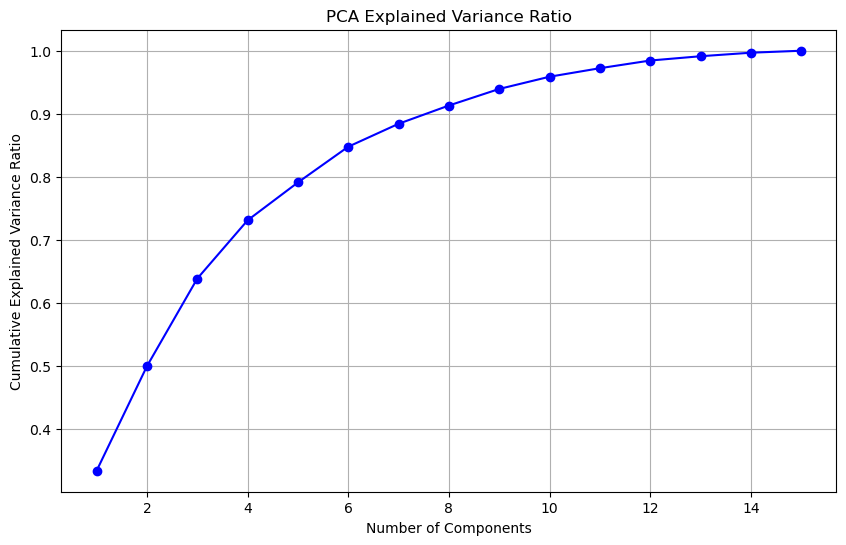

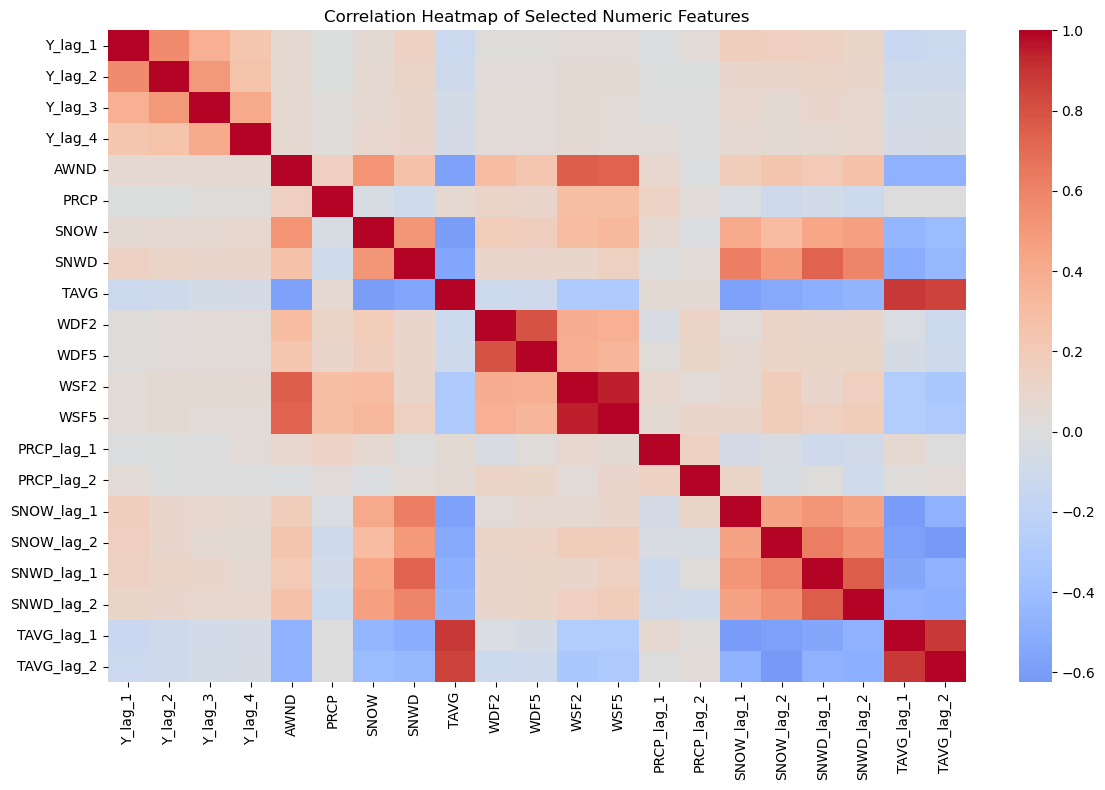


Final Dataset Columns:

Categorical columns: ['year', 'week_start', 'neighborhood', 'request_type_name']

PCA components: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

Target column: Y


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# 1. Separate features
categorical_cols = ['year', 'week_start', 'neighborhood', 'request_type_name']
target_col = 'Y'
numeric_cols = [col for col in final_df.columns 
                if col not in categorical_cols + [target_col]]

# Create numeric feature matrix while preserving categorical columns and target
X_numeric = final_df[numeric_cols].copy()
df_numeric = pd.concat([
    final_df[categorical_cols],  # Categorical columns
    X_numeric,                   # Numeric features
    final_df[target_col]        # Target variable
], axis=1)

# A. Correlation Filtering
def correlation_filter(df, categorical_cols, target_col, threshold=0.95):
    # Separate numeric features
    numeric_features = [col for col in df.columns 
                       if col not in categorical_cols + [target_col]]
    X = df[numeric_features]
    
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Features dropped due to high correlation (>{threshold}):")
    for col in to_drop:
        corr_with = upper[col][upper[col] > threshold].index.tolist()
        print(f"{col} correlated with: {corr_with}")
    
    # Create new dataframe with selected features, categorical columns, and target
    X_filtered = X.drop(columns=to_drop)
    df_filtered = pd.concat([
        df[categorical_cols],
        X_filtered,
        df[target_col]
    ], axis=1)
    
    return df_filtered, to_drop

# Apply correlation filtering
df_numeric_corr, dropped_corr = correlation_filter(df_numeric, categorical_cols, target_col, threshold=0.95)
print(f"\nShape after correlation filtering: {df_numeric_corr.shape}")

# B. Variance Thresholding
def variance_filter(df, categorical_cols, target_col, threshold=0.01):
    # Separate numeric features
    numeric_features = [col for col in df.columns 
                       if col not in categorical_cols + [target_col]]
    X = df[numeric_features]
    
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    
    # Get features to keep
    features_to_keep = X.columns[selector.get_support()].tolist()
    features_to_drop = [col for col in X.columns if col not in features_to_keep]
    
    print(f"\nFeatures dropped due to low variance (<{threshold}):")
    print(features_to_drop)
    
    # Create new dataframe with selected features, categorical columns, and target
    X_filtered = X[features_to_keep]
    df_filtered = pd.concat([
        df[categorical_cols],
        X_filtered,
        df[target_col]
    ], axis=1)
    
    return df_filtered, features_to_drop

# Apply variance thresholding
df_numeric_var01, dropped_var = variance_filter(df_numeric_corr, categorical_cols, target_col, threshold=0.01)
print(f"\nShape after variance thresholding 0.01: {df_numeric_var01.shape}")

df_numeric_var05, dropped_var = variance_filter(df_numeric_corr, categorical_cols, target_col, threshold=0.05)
print(f"\nShape after variance thresholding 0.05: {df_numeric_var05.shape}")

# C. PCA
def apply_pca(df, categorical_cols, target_col, n_components=None):
    # Separate numeric features
    numeric_features = [col for col in df.columns 
                       if col not in categorical_cols + [target_col]]
    X = df[numeric_features]
    
    # Standardize the numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create DataFrame with PCA components
    pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)
    
    # Combine PCA components with categorical columns and target
    df_final = pd.concat([
        df[categorical_cols],
        df_pca,
        df[target_col]
    ], axis=1)
    
    return df_final, pca, scaler

# First, analyze explained variance with full PCA
numeric_features = [col for col in df_numeric_var05.columns 
                   if col not in categorical_cols + [target_col]]
X_for_pca = df_numeric_var05[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_pca)
pca_full = PCA().fit(X_scaled)

# Calculate explained variance ratio
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print("\nPCA Analysis:")
print(f"Number of components needed for 95% variance: {n_components_95}")
print("\nExplained variance ratio by component:")
for i, ratio in enumerate(pca_full.explained_variance_ratio_):
    print(f"Component {i+1}: {ratio:.4f}")

# Create final PCA transformation if needed
if n_components_95 < len(numeric_features):
    df_pca_final, pca_final, scaler_final = apply_pca(
        df_numeric_var01, categorical_cols, target_col, n_components_95
    )
    print(f"\nFinal shape after PCA: {df_pca_final.shape}")

# Create a summary of the feature selection process
print("\nFeature Selection Summary:")
print(f"Original numeric features: {len(numeric_cols)}")
print(f"Categorical features maintained: {len(categorical_cols)}")
print(f"Features after correlation filtering: {len([col for col in df_numeric_corr.columns if col not in categorical_cols + [target_col]])}")
print(f"Features after variance thresholding 0.01: {len([col for col in df_numeric_var01.columns if col not in categorical_cols + [target_col]])}")
print(f"Features after variance thresholding 0.05: {len([col for col in df_numeric_var05.columns if col not in categorical_cols + [target_col]])}")
print(f"Features after PCA (95% variance): {n_components_95}")
print(f"Total features in final PCA dataset: {n_components_95 + len(categorical_cols)}")

# Optional: Plot explained variance ratio
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Create a correlation heatmap of the numeric features before PCA
numeric_features = [col for col in df_numeric_var01.columns 
                   if col not in categorical_cols + [target_col]]
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric_var01[numeric_features].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Selected Numeric Features')
plt.tight_layout()
plt.show()

# Now you have these dataframes available:
# 1. df_numeric: Original features (categorical + numeric + target)
# 2. df_numeric_corr: After correlation filtering (categorical + filtered numeric + target)
# 3. df_numeric_var: After variance thresholding (categorical + filtered numeric + target)
# 4. df_pca_final: After PCA (categorical + PCA components + target)

print("\nFinal Dataset Columns:")
print("\nCategorical columns:", categorical_cols)
if 'df_pca_final' in locals():
    print("\nPCA components:", [col for col in df_pca_final.columns 
                              if col.startswith('PC')])
print("\nTarget column:", target_col)

In [14]:
df_numeric

# 1. df_numeric: Original features (categorical + numeric + target)
# 2. df_numeric_corr: After correlation filtering (categorical + filtered numeric + target)
# 3. df_numeric_var(01/05): After variance thresholding (categorical + filtered numeric + target)
# 4. df_pca_final: After PCA (categorical + PCA components + target)

,year,week_start,neighborhood,request_type_name,Y_lag_1,Y_lag_2,Y_lag_3,Y_lag_4,AWND,PRCP,...,SNOW_lag_2,SNWD_lag_1,SNWD_lag_2,TAVG_lag_1,TAVG_lag_2,TMAX_lag_1,TMAX_lag_2,TMIN_lag_1,TMIN_lag_2,Y
4,2024,2024-05-27,Allegheny Center,Barricades,1.0,1.0,1.0,1.0,7.000505,0.091227,...,0.0,0.000000,0.0,74.397163,65.460674,84.148936,75.310861,62.904255,55.925094,1
13,2022,2022-06-20,Allegheny Center,"Litter Can, Public",1.0,1.0,1.0,1.0,6.327155,0.116667,...,0.0,0.000000,0.0,76.091644,66.054920,85.078167,76.240275,67.123989,55.681922,1
14,2022,2022-08-22,Allegheny Center,"Litter Can, Public",1.0,1.0,1.0,1.0,4.888014,0.152624,...,0.0,0.000000,0.0,68.465278,72.469595,79.277778,78.625000,59.420139,65.337838,2
15,2022,2022-12-05,Allegheny Center,"Litter Can, Public",2.0,1.0,1.0,1.0,5.710331,0.067417,...,0.0,0.000000,0.0,40.354839,35.162393,49.864516,49.136752,31.561290,23.863248,1
16,2022,2022-12-19,Allegheny Center,"Litter Can, Public",1.0,2.0,1.0,1.0,10.641667,0.058167,...,0.0,0.471967,0.0,31.184100,41.509934,34.389121,49.668874,28.020921,34.503311,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21886,2023,2023-07-10,Windgap,Tree Fallen Across Road,1.0,2.0,1.0,1.0,5.726152,0.011320,...,0.0,0.000000,0.0,74.462222,68.500000,83.617778,76.058333,65.084444,61.637500,1
21887,2023,2023-09-25,Windgap,Tree Fallen Across Road,1.0,1.0,2.0,1.0,6.211369,0.057321,...,0.0,0.000000,0.0,63.297753,65.222727,74.719101,76.150000,53.494382,56.100000,1
21888,2024,2024-02-19,Windgap,Tree Fallen Across Road,1.0,1.0,1.0,2.0,4.382845,0.063556,...,0.0,0.378453,0.0,34.497238,41.343137,44.359116,53.774510,25.276243,31.245098,1
21889,2024,2024-05-13,Windgap,Tree Fallen Across Road,1.0,1.0,1.0,1.0,4.999101,0.128727,...,0.0,0.000000,0.0,63.719231,70.831933,71.476923,80.983193,55.492308,57.352941,1


#### 3. Modeling

**A. Split Data**
- Time-based split: Train on 2022–2023, validate on early 2024

**B. Model Selection**
- Use **LightGBM Regressor** (or XGBoost)
- Train to predict `request_count` per (week, neighborhood, type)

**C. Evaluation**
- Metrics: **MAE**, **RMSE**
- (Optional: SHAP or Permutation Importance)

**D. Output**
- Weekly predictions with uncertainty
- Integrate into report/alert system for DPW manager

In [15]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from lightgbm import LGBMRegressor
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde
from scipy import stats


In [104]:
class DataPreparation:
    def __init__(self, df, target_col='Y', date_col='week_start',
                 cat_cols=['neighborhood', 'request_type_name'],
                 exclude_cols=None):
        """
        Initialize data preparation with flexible date splitting
        """
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        self.cat_cols = cat_cols
        self.exclude_cols = exclude_cols or []
        
        # Convert date column to datetime
        self.df[date_col] = pd.to_datetime(self.df[date_col])
        
        # Store data splits
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
    def prepare_features(self):
        """Prepare feature matrix X and target vector y"""
        exclude = [self.target_col, self.date_col] + self.exclude_cols
        feature_cols = [col for col in self.df.columns if col not in exclude]
        
        X = self.df[feature_cols].copy()
        
        # Encode categorical variables
        for col in self.cat_cols:
            if col in X.columns:
                X[col] = pd.Categorical(X[col]).codes
                
        return X, self.df[self.target_col]
    
    def validate_data(self, X, y):  # Add self parameter here
        """Validate data before training"""
        print("\nData Validation:")
        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")
        print("\nFeature statistics:")
        print(X.describe().round(2))
        print("\nTarget statistics:")
        print(y.describe().round(2))
        
        # Check for infinite or NaN values
        if X.isnull().any().any() or y.isnull().any():
            print("Warning: Dataset contains NaN values")
        if np.isinf(X.values).any() or np.isinf(y.values).any():
            print("Warning: Dataset contains infinite values")
    
    def split_data(self, train_years=2, val_months=2):
        """
        Split data into train/validation/test sets
        
        Parameters:
        -----------
        train_years : int, number of years for training
        val_months : int, number of months for validation
        """
        # Get date range
        min_date = self.df[self.date_col].min()
        max_date = self.df[self.date_col].max()
        
        # Calculate split dates
        train_end = min_date + pd.DateOffset(years=train_years)
        val_end = train_end + pd.DateOffset(months=val_months)
        
        # Create masks
        train_mask = self.df[self.date_col] <= train_end
        val_mask = (self.df[self.date_col] > train_end) & (self.df[self.date_col] <= val_end)
        test_mask = self.df[self.date_col] > val_end
        
        # Prepare features
        X, y = self.prepare_features()
        
        # Split data
        self.X_train = X[train_mask]
        self.X_val = X[val_mask]
        self.X_test = X[test_mask]
        self.y_train = y[train_mask]
        self.y_val = y[val_mask]
        self.y_test = y[test_mask]
        
        # Print summary
        print("\nData Split Summary:")
        print(f"Total date range: {min_date.date()} to {max_date.date()}")
        print(f"Training period: {min_date.date()} to {train_end.date()}")
        print(f"Validation period: {train_end.date()} to {val_end.date()}")
        print(f"Testing period: {val_end.date()} to {max_date.date()}")
        print("\nSample sizes:")
        print(f"Training: {len(self.X_train):,} samples")
        print(f"Validation: {len(self.X_val):,} samples")
        print(f"Testing: {len(self.X_test):,} samples")

        # Validate data before returning
        print("\nValidating training data:")
        self.validate_data(self.X_train, self.y_train)
        print("\nValidating validation data:")
        self.validate_data(self.X_val, self.y_val)
            
        return (self.X_train, self.X_val, self.X_test,
                self.y_train, self.y_val, self.y_test)



In [105]:
class MLPipeline:
    def __init__(self, model_name, model, scaler=StandardScaler(), 
                 use_pca=False, n_components=None, 
                 use_feature_selection=False, n_features=None):
        """Initialize ML Pipeline with PCA and feature selection options
        
        Parameters:
        -----------
        model_name : str
            Name of the model
        model : estimator object
            The model to be used
        scaler : transformer object, default=StandardScaler()
            The scaler to be used for feature scaling
        use_pca : bool, default=False
            Whether to use PCA for dimensionality reduction
        n_components : int or float, optional
            Number of components for PCA. If float, represents variance to be explained
        use_feature_selection : bool, default=False
            Whether to use feature selection
        n_features : int, optional
            Number of features to select using SelectKBest
        """
        self.model_name = model_name
        self.is_baseline = model is None
        self.use_pca = use_pca
        self.use_feature_selection = use_feature_selection
        self.val_predictions = None
        self.val_errors = None
        self.val_metrics = None
        self.training_metrics = None
        self.training_features = None
        
        
        if not self.is_baseline:
            steps = [('scaler', scaler)]
            
            # Add PCA if specified
            if use_pca:
                if n_components is None:
                    n_components = 0.95  # Default: explain 95% of variance
                steps.append(('pca', PCA(n_components=n_components)))
            
            # Add feature selection if specified
            if use_feature_selection:
                if n_features is None:
                    n_features = 'all'  # Default: select all features
                steps.append(('feature_selection', SelectKBest(score_func=f_regression, k=n_features)))
            
            # Add the model
            steps.append(('model', model))
            
            self.pipeline = Pipeline(steps)
        else:
            self.pipeline = None
            
        self.training_time = None
        self.feature_names = None
        self.selected_features_mask = None
        self.n_components_selected = None

    def get_feature_importance_info(self):
        """Get feature importance and transformation information"""
        if self.is_baseline:
            return None
            
        info = {}
        
        # Feature selection information
        if self.use_feature_selection:
            selected_features = np.array(self.feature_names)[self.selected_features_mask]
            info['selected_features'] = selected_features
            info['n_selected_features'] = len(selected_features)
            
        # PCA information
        if self.use_pca:
            pca = self.pipeline.named_steps['pca']
            info['n_pca_components'] = self.n_components_selected
            info['explained_variance_ratio'] = pca.explained_variance_ratio_
            info['cumulative_variance_ratio'] = np.cumsum(pca.explained_variance_ratio_)
            
        # Model feature importances if available
        if hasattr(self.pipeline['model'], 'feature_importances_'):
            if self.use_feature_selection:
                # Get feature importances for selected features only
                importances = pd.Series(
                    self.pipeline['model'].feature_importances_,
                    index=np.array(self.feature_names)[self.selected_features_mask]
                )
            else:
                importances = pd.Series(
                    self.pipeline['model'].feature_importances_,
                    index=self.feature_names
                )
            
            # Sort and clean feature names for better visualization
            importances = importances.sort_values(ascending=True)  # Changed to ascending=True for horizontal bar plot
            
            # Clean feature names
            clean_names = importances.index.map(lambda x: x.replace('_', ' ').title())
            importances.index = clean_names
            
            info['feature_importances'] = importances
            
        return info
        
    def fit(self, X, y):
        """Fit method that handles both baseline and regular models"""
        self.feature_names = X.columns.tolist()
        self.training_features = X.columns.tolist()
        self.feature_names = self.training_features
        
        if self.is_baseline:
            return self
        if not self.is_baseline:
            self.pipeline.fit(X, y)
            
            # Store feature selection mask if used
            if self.use_feature_selection:
                self.selected_features_mask = self.pipeline.named_steps['feature_selection'].get_support()
                
            # Store number of PCA components if used
            if self.use_pca:
                self.n_components_selected = self.pipeline.named_steps['pca'].n_components_
                
        return self
    
    def predict(self, X):
        """Predict method that handles both baseline and regular models"""
        if self.is_baseline:
            return self.get_baseline_predictions(X)
        return self.pipeline.predict(X)
    
    @staticmethod
    def get_baseline_predictions(X):
        """Baseline model: average of last 4 weeks"""
        lag_cols = [col for col in X.columns if 'Y_lag' in col]
        return X[lag_cols].mean(axis=1)
    
    def get_feature_importances(self):
        """Get feature importance if the model supports it"""
        if self.is_baseline:
            return None
        if hasattr(self.pipeline['model'], 'feature_importances_'):
            return self.pipeline['model'].feature_importances_
        return None
        
    def train_evaluate(self, X_train, X_val, y_train, y_val):
        """Train and evaluate model"""
        self.feature_names = X_train.columns.tolist()
        
        start_time = time.time()
        self.fit(X_train, y_train)
        self.training_time = time.time() - start_time
        
        # Use the class's predict method which handles both cases
        y_train_pred = self.predict(X_train)
        y_val_pred = self.predict(X_val)
        
        # Store validation predictions and errors
        self.val_predictions = y_val_pred
        self.val_errors = abs(y_val - y_val_pred)
        
        # Calculate and store metrics
        self.training_metrics = self.calculate_metrics(y_train, y_train_pred, "Training")
        self.val_metrics = self.calculate_metrics(y_val, y_val_pred, "Validation")
        
        return self.training_metrics, self.val_metrics, y_val_pred

    def calculate_metrics(self, y_true, y_pred, dataset_name):
        """
        Calculate comprehensive metrics
        """
        metrics = {
            'Dataset': dataset_name,
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MSE': mean_squared_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'Mean Absolute Percentage Error': np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100,
            'Mean Prediction': np.mean(y_pred),
            'Mean Actual': np.mean(y_true),
            'Max Error': np.max(np.abs(y_true - y_pred)),
            'Samples': len(y_true)
        }
        return metrics
    
    def print_summary(self, train_metrics, val_metrics):
        """Print detailed summary of the model performance including PCA and feature selection info"""
        print(f"\n{'='*50}")
        print(f"Model: {self.model_name}")
        print(f"{'='*50}")
        
        print("\nModel Configuration:")
        print(f"Using PCA: {self.use_pca}")
        print(f"Using Feature Selection: {self.use_feature_selection}")
        
        print("\nTraining Information:")
        print(f"Number of original features: {len(self.feature_names)}")
        print(f"Training time: {self.training_time:.2f} seconds")
        print(f"Training samples: {train_metrics['Samples']}")
        print(f"Validation samples: {val_metrics['Samples']}")
        
        # Get and print transformation info
        if not self.is_baseline:
            info = self.get_feature_importance_info()
            
            if info:
                if self.use_pca:
                    print(f"\nPCA Information:")
                    print(f"Number of components: {info['n_pca_components']}")
                    print(f"Cumulative explained variance ratio: {info['cumulative_variance_ratio'][-1]:.3f}")
                
                if self.use_feature_selection:
                    print(f"\nFeature Selection Information:")
                    print(f"Number of selected features: {info['n_selected_features']}")
                    print("\nSelected Features:")
                    print(info['selected_features'])
                
                if 'feature_importances' in info:
                    print("\nTop 10 Feature Importances:")
                    print(info['feature_importances'].head(10).round(4))
        
        print("\nMetrics:")
        metrics_df = pd.DataFrame([train_metrics, val_metrics])
        print(metrics_df.round(4))
    
    def plot_predictions(self, y_true, y_pred, title=None):
        """
        Create visualization of predictions with smoothed error distribution
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Scatter plot
        ax1.scatter(y_true, y_pred, alpha=0.5)
        max_val = max(y_true.max(), y_pred.max())
        ax1.plot([0, max_val], [0, max_val], 'r--')
        ax1.set_xlabel('Actual Values')
        ax1.set_ylabel('Predicted Values')
        ax1.set_title('Actual vs Predicted')
        
        # Error distribution with smooth line
        errors = abs(y_true - y_pred)
        
        # Plot histogram
        counts, bins, _ = ax2.hist(errors, bins=50, alpha=0.75, density=True)
        
        # Add KDE smooth line
        kde = gaussian_kde(errors)
        x_range = np.linspace(errors.min(), errors.max(), 200)
        ax2.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Density Estimate')
        
        ax2.set_xlabel('Prediction Error')
        ax2.set_ylabel('Density')
        ax2.set_title('Error Distribution')
        ax2.legend()
        
        plt.suptitle(f"{self.model_name} Prediction Analysis")
        plt.tight_layout()
        plt.show()



In [106]:
def train_single_model(df, model_name, model_config, use_pca=False, use_feature_selection=False, existing_models=None, data_prep=None):
    """
    Train and evaluate a single model with optional PCA or feature selection
    
    Parameters:
    -----------
    df : DataFrame
        Input data
    model_name : str
        Name of the model
    model_config : dict
        Model configuration containing the model parameters
    use_pca : bool, default=False
        Whether to use PCA (will explain 95% variance if True)
    use_feature_selection : bool, default=False
        Whether to use feature selection (will select top 20 features if True)
    data_prep : DataPreparation, optional
        Existing DataPreparation instance to use
    
    Returns:
    --------
    data_prep : DataPreparation
        Data preparation instance
    trained_model : MLPipeline
        Trained model pipeline
    """
    # Initialize or use existing models dictionary
    all_models = existing_models if existing_models is not None else {}
    
    # 1. Prepare Data
    if data_prep is None:
        print("Preparing data...")
        data_prep = DataPreparation(df)
        X_train, X_val, X_test, y_train, y_val, y_test = data_prep.split_data()
    else:
        print("Using existing data preparation...")
        X_train, X_val = data_prep.X_train, data_prep.X_val
        y_train, y_val = data_prep.y_train, data_prep.y_val
    
    # 2. Configure and train model
    print(f"\nTraining {model_name}...")
    pipeline = MLPipeline(
        model_name=model_name,
        model=model_config['model'],
        use_pca=use_pca,
        n_components=0.95 if use_pca else None,
        use_feature_selection=use_feature_selection,
        n_features=20 if use_feature_selection else None
    )
    
    # Train and evaluate
    train_metrics, val_metrics, y_val_pred = pipeline.train_evaluate(
        X_train, X_val, y_train, y_val
    )
    
    # Print summary and plot results
    pipeline.print_summary(train_metrics, val_metrics)
    pipeline.plot_predictions(y_val, y_val_pred)
    
    
    # Add to models dictionary
    all_models[model_name] = pipeline
    
    return data_prep, pipeline, all_models


Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 30)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

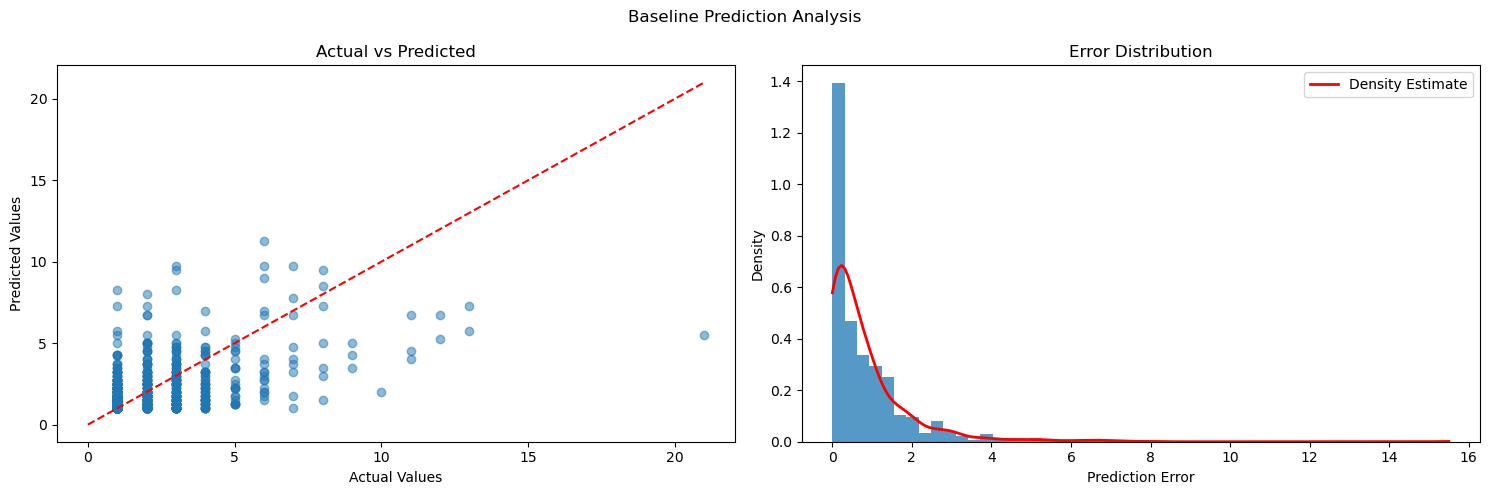

In [107]:
# Initialize empty dictionary for models
trained_models = {}
data_prep_dict = {}

# Train baseline model first (this will create the data_prep)
data_prep, baseline_model, trained_models = train_single_model(
    df=df_numeric,
    model_name='Baseline',
    model_config={'model': None},
    existing_models=trained_models
)

data_prep_dict['Baseline'] = data_prep


Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 30)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

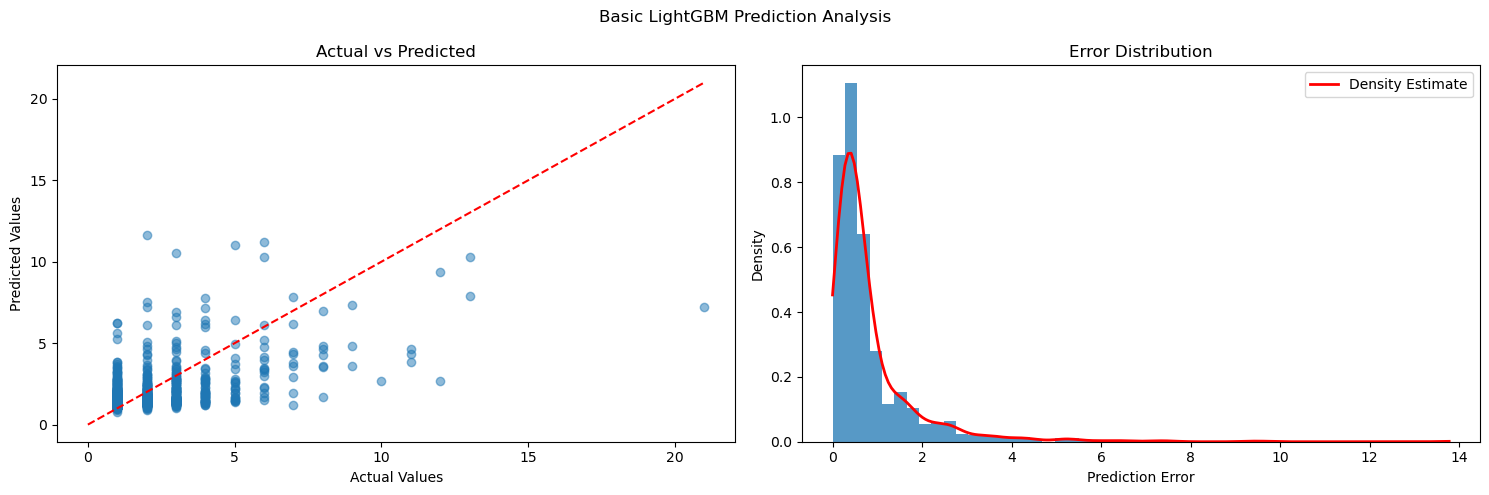

In [108]:
# Train basic LightGBM using the same data_prep
data_prep_dict['Basic LightGBM'], basic_lgbm, trained_models = train_single_model(
    df=final_df,
    model_name='Basic LightGBM',
    model_config={
        'model': LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31
        )
    },
    existing_models=trained_models
)

Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 24)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

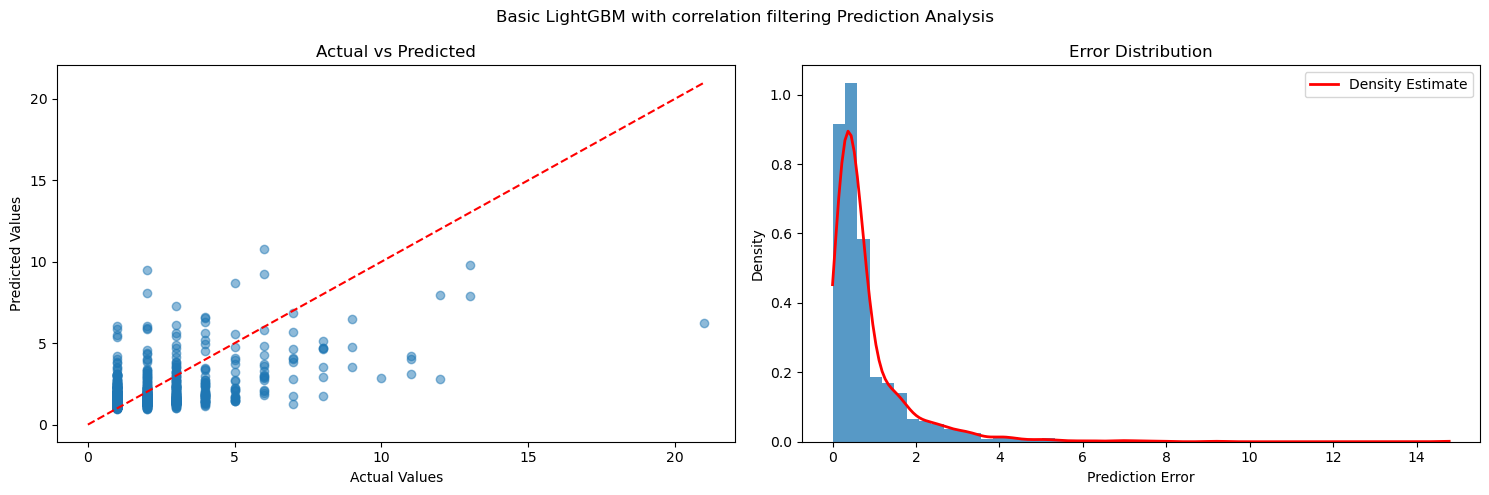

In [109]:
# Train basic LightGBM using the same data_prep
data_prep_dict['Basic LightGBM with correlation filtering'], basic_lgbm_corr, trained_models = train_single_model(
    df=df_numeric_corr,
    model_name='Basic LightGBM with correlation filtering',
    model_config={
        'model': LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31
        )
    },
    existing_models=trained_models
)

Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 13)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name       PC1       PC2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      0.24      0.00   
std        0.65         24.75               3.33      1.83      1.59   
min     2022.00          0.00               0.00     -6.23     -5.63   
25%     2022.00         17.00               7.00     -0.96     -1.18   
50%     2023.00         43.00              10.00      0.80      0.22   
75%     2023.00         65.00              10.00      1.71      1.20   
max     2

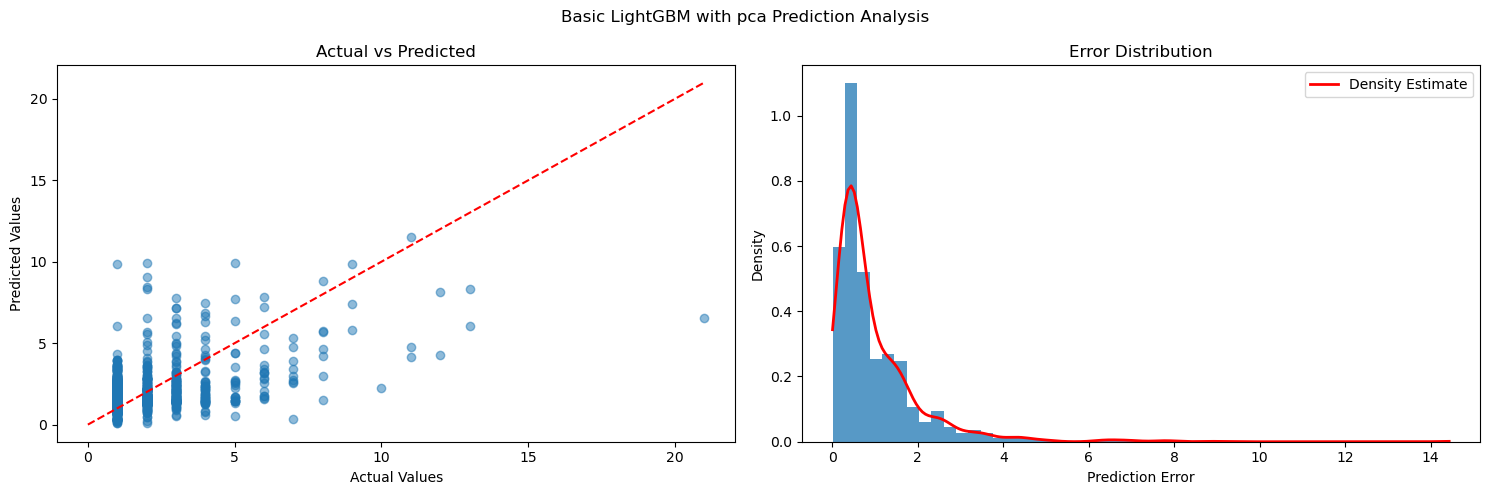

In [110]:
# Train basic LightGBM using the same data_prep
data_prep_dict['Basic LightGBM with pca'], basic_lgbm_pca, trained_models = train_single_model(
    df=df_pca_final,
    model_name='Basic LightGBM with pca',
    model_config={
        'model': LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31
        )
    },
    existing_models=trained_models
)

Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 18)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

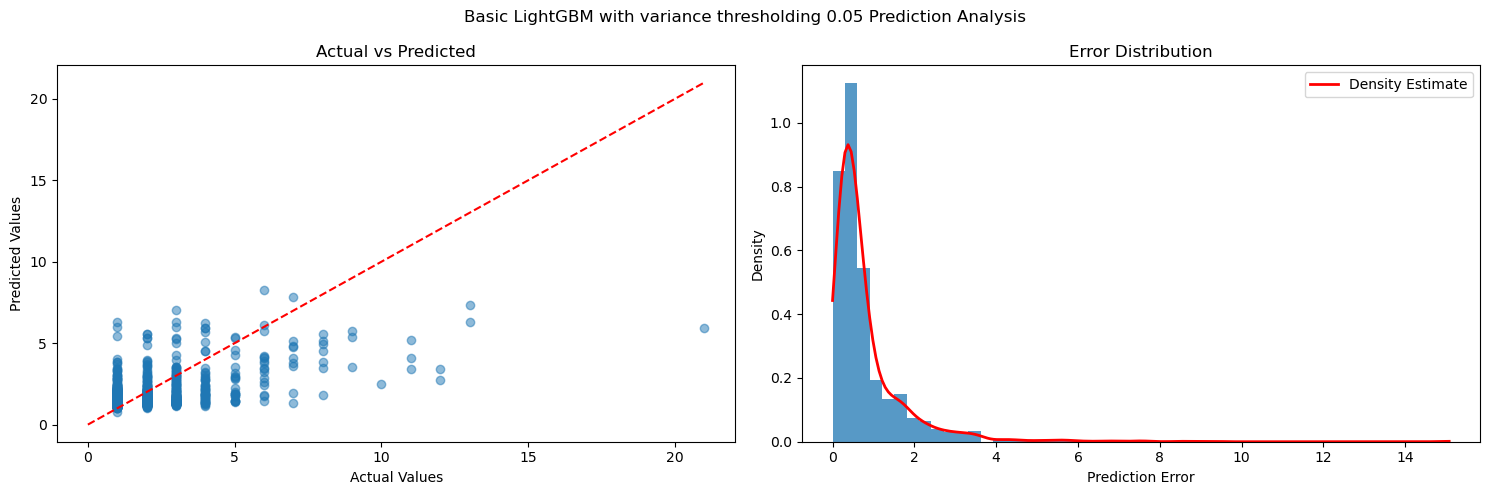

In [111]:
# Train basic LightGBM using the same data_prep
data_prep_dict['Basic LightGBM with variance thresholding 0.05'], basic_lgbm_var05, trained_models = train_single_model(
    df=df_numeric_var05,
    model_name='Basic LightGBM with variance thresholding 0.05',
    model_config={
        'model': LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31
        )
    },
    existing_models=trained_models
)

Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 18)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

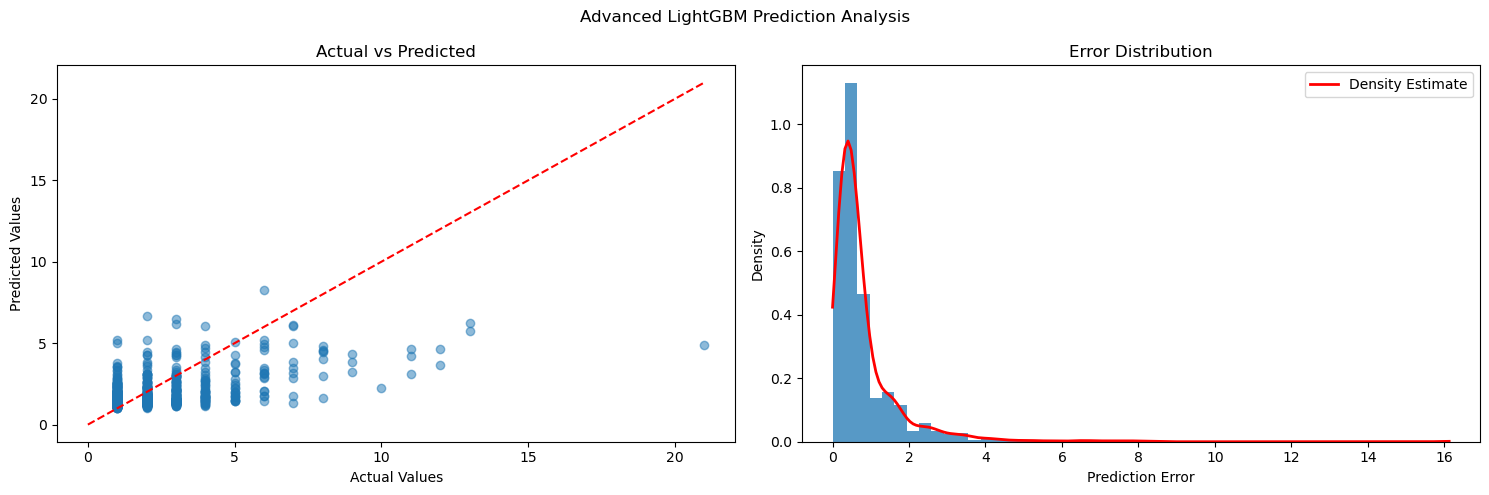

In [112]:
# Train advanced LightGBM
data_prep_dict['Advanced LightGBM'], advanced_lgbm, trained_models = train_single_model(
    df=df_numeric_var05,
    model_name='Advanced LightGBM',
    model_config={
        'model': LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            num_leaves=31,
            max_depth=6,
            min_child_samples=20,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42
        )
    },
    existing_models=trained_models
)

Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 18)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

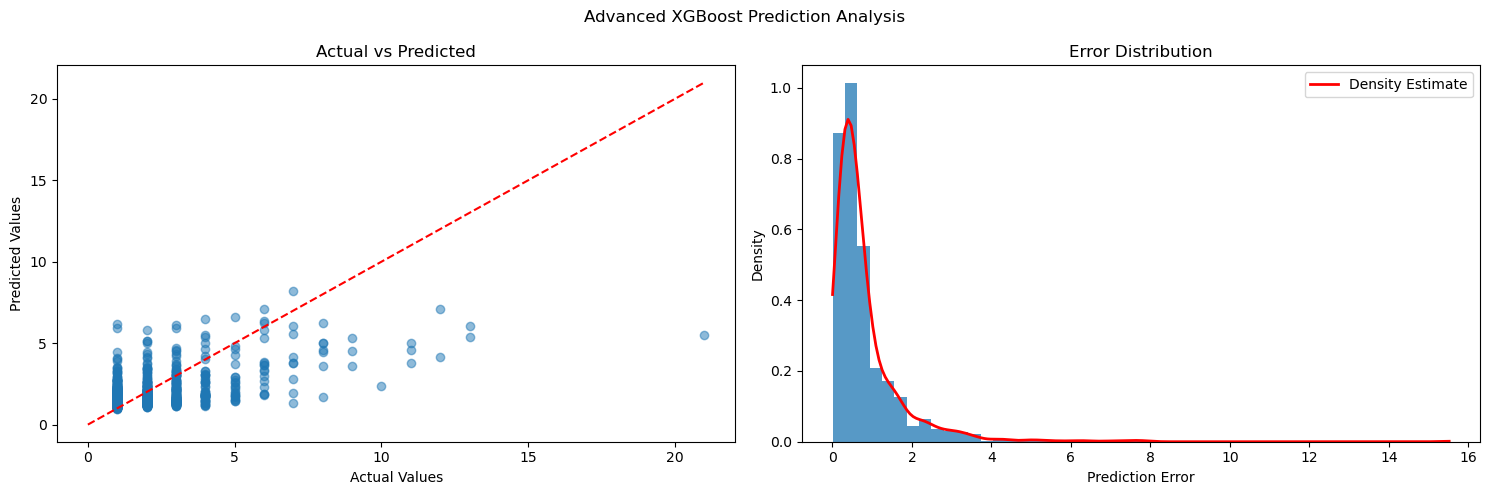

In [113]:
from xgboost import XGBRegressor

# Train XGBoost model with optimized parameters
data_prep_dict['Advanced XGBoost'], xgboost_model, trained_models = train_single_model(
    df=df_numeric_var05,
    model_name='Advanced XGBoost',
    model_config={
        'model': XGBRegressor(
            # Tree parameters
            n_estimators=200,          
            max_depth=6,               
            min_child_weight=1,        
            
            # Learning parameters
            learning_rate=0.05,        
            subsample=0.8,             
            colsample_bytree=0.8,      
            
            # Regularization parameters
            reg_alpha=0.1,             
            reg_lambda=1.0,            
            
            # Other parameters
            objective='reg:squarederror',
            random_state=42,           
            n_jobs=-1                  
            # Removed early_stopping_rounds and eval_metric from here
        ),
        'fit_params': {
            # Add validation set and early stopping parameters here
            'eval_set': [(data_prep.X_val, data_prep.y_val)],
            'early_stopping_rounds': 20,
            'eval_metric': ['rmse', 'mae'],
            'verbose': False
        }
    },
    existing_models=trained_models
)

Preparing data...

Data Split Summary:
Total date range: 2022-03-28 to 2025-02-03
Training period: 2022-03-28 to 2024-03-28
Validation period: 2024-03-28 to 2024-05-28
Testing period: 2024-05-28 to 2025-02-03

Sample sizes:
Training: 11,408 samples
Validation: 1,343 samples
Testing: 4,482 samples

Validating training data:

Data Validation:
Features shape: (11408, 18)
Target shape: (11408,)

Feature statistics:
           year  neighborhood  request_type_name   Y_lag_1   Y_lag_2  \
count  11408.00      11408.00           11408.00  11408.00  11408.00   
mean    2022.78         42.33               9.09      1.87      1.85   
std        0.65         24.75               3.33      2.43      2.32   
min     2022.00          0.00               0.00      1.00      1.00   
25%     2022.00         17.00               7.00      1.00      1.00   
50%     2023.00         43.00              10.00      1.00      1.00   
75%     2023.00         65.00              10.00      2.00      2.00   
max     2

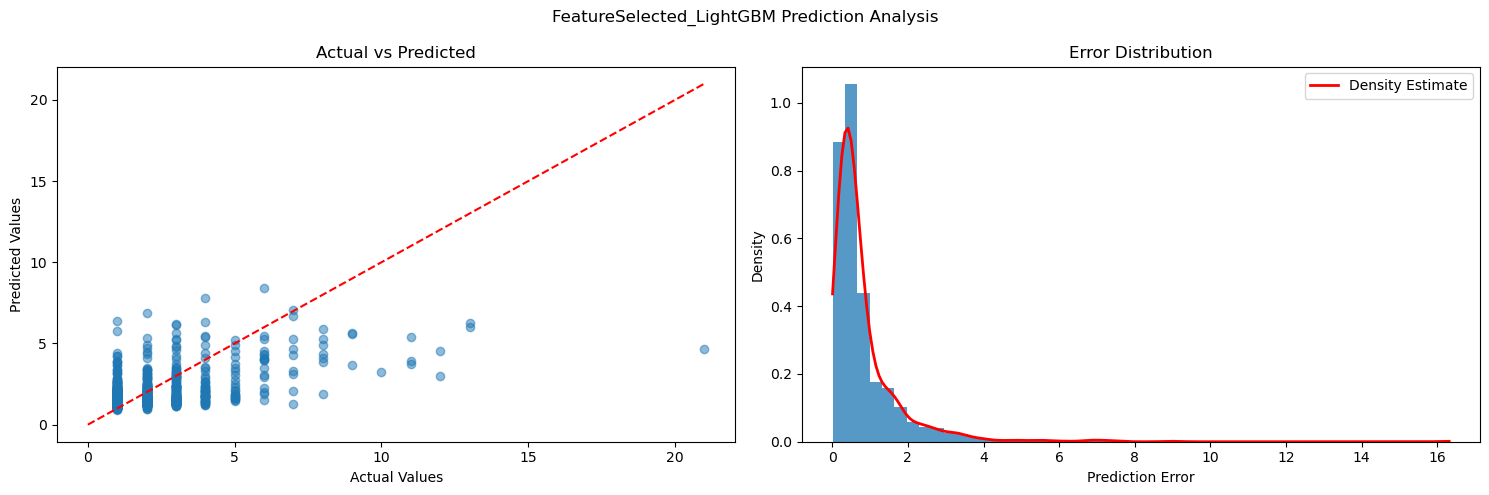

In [114]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Feature selection using LASSO
data_prep_dict['FeatureSelected_LightGBM'], feature_selected_lgbm, trained_models = train_single_model(
    df=df_numeric_var05,
    model_name='FeatureSelected_LightGBM',
    model_config={
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectFromModel(Lasso(alpha=0.01))),
            ('lgbm', LGBMRegressor(
                n_estimators=100,
                learning_rate=0.1,
                num_leaves=31
            ))
        ])
    },
    existing_models=trained_models
)

In [115]:
# ### TRY ON ADDING INTERACTION FEATURES
# def create_interaction_features(X):
#     # Create interaction between weather and temporal features
#     X['temp_snow'] = X['TAVG'] * X['SNOW']
#     X['temp_prcp'] = X['TAVG'] * X['PRCP']
    
#     # Create rolling statistics for lag features
#     lag_cols = [col for col in X.columns if 'lag' in col]
#     X['lag_mean'] = X[lag_cols].mean(axis=1)
#     X['lag_std'] = X[lag_cols].std(axis=1)
    
#     # Create seasonal features
#     X['month'] = pd.to_datetime(X.index).month
#     X['is_winter'] = X['month'].isin([12, 1, 2]).astype(int)
    
#     return X

# interaction_df = create_interaction_features(final_df)
# interaction_df


# # Create a new DataPreparation instance for the enhanced model
# enhanced_data_prep = DataPreparation(interaction_df)
# X_train_enhanced, X_val_enhanced, X_test_enhanced, y_train_enhanced, y_val_enhanced, y_test_enhanced = enhanced_data_prep.split_data()



In [116]:

# # Train XGBoost model with interaction features
# _, xgboost_interaction_model, trained_models = train_single_model(
#     df=interaction_df,
#     model_name='Advanced XGBoost plus interaction features',
#     model_config={
#         'model': XGBRegressor(
#             # Tree parameters
#             n_estimators=200,          
#             max_depth=6,               
#             min_child_weight=1,        
            
#             # Learning parameters
#             learning_rate=0.05,        
#             subsample=0.8,             
#             colsample_bytree=0.8,      
            
#             # Regularization parameters
#             reg_alpha=0.1,             
#             reg_lambda=1.0,            
            
#             # Other parameters
#             objective='reg:squarederror',
#             random_state=42,           
#             n_jobs=-1                  
#             # Removed early_stopping_rounds and eval_metric from here
#         )
#     },
#     existing_models=trained_models,
#     data_prep=enhanced_data_prep
# )

In [117]:
trained_models


{'Baseline': <__main__.MLPipeline at 0x2823206e0>,
 'Basic LightGBM': <__main__.MLPipeline at 0x17ff32060>,
 'Basic LightGBM with correlation filtering': <__main__.MLPipeline at 0x17d6929c0>,
 'Basic LightGBM with pca': <__main__.MLPipeline at 0x15015ec30>,
 'Basic LightGBM with variance thresholding 0.05': <__main__.MLPipeline at 0x1503e27b0>,
 'Advanced LightGBM': <__main__.MLPipeline at 0x1508916d0>,
 'Advanced XGBoost': <__main__.MLPipeline at 0x1508d3230>,
 'FeatureSelected_LightGBM': <__main__.MLPipeline at 0x1502b0ef0>}

In [118]:
data_prep_dict

{'Baseline': <__main__.DataPreparation at 0x17d711e80>,
 'Basic LightGBM': <__main__.DataPreparation at 0x17ff33c20>,
 'Basic LightGBM with correlation filtering': <__main__.DataPreparation at 0x150269eb0>,
 'Basic LightGBM with pca': <__main__.DataPreparation at 0x17ffb5820>,
 'Basic LightGBM with variance thresholding 0.05': <__main__.DataPreparation at 0x1503e0a40>,
 'Advanced LightGBM': <__main__.DataPreparation at 0x1508e0b60>,
 'Advanced XGBoost': <__main__.DataPreparation at 0x1508d1250>,
 'FeatureSelected_LightGBM': <__main__.DataPreparation at 0x150848650>}


Aggregated Model Metrics:
                                            Model     Dataset     MAE    RMSE  \
0                                        Baseline  Validation  0.8340  1.4191   
1                                  Basic LightGBM  Validation  0.8332  1.3523   
2       Basic LightGBM with correlation filtering  Validation  0.8271  1.3317   
3                         Basic LightGBM with pca  Validation  0.9827  1.4697   
4  Basic LightGBM with variance thresholding 0.05  Validation  0.8092  1.3007   
5                               Advanced LightGBM  Validation  0.8075  1.3080   
6                                Advanced XGBoost  Validation  0.8180  1.2862   
7                        FeatureSelected_LightGBM  Validation  0.8108  1.2993   

      MSE      R2  Mean Absolute Percentage Error  Mean Prediction  \
0  2.0138  0.1929                         26.6880           1.8075   
1  1.8288  0.2670                         27.2615           1.8145   
2  1.7735  0.2892                

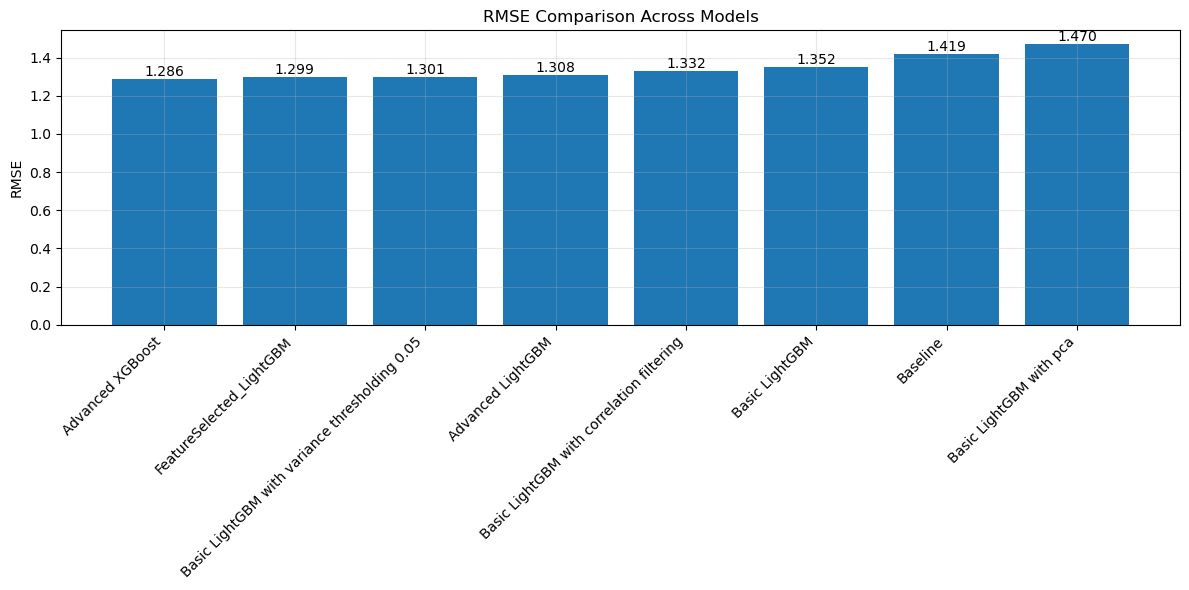

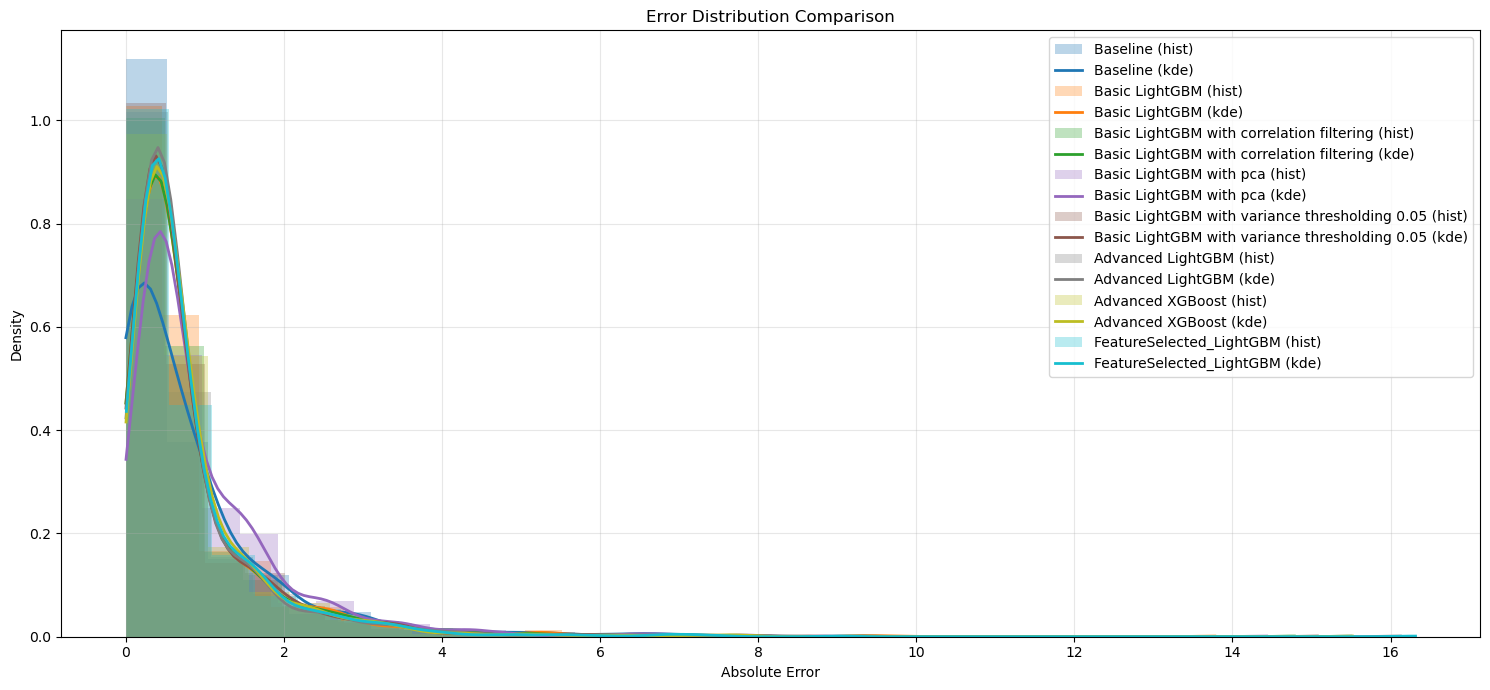

In [119]:
def aggregate_model_metrics(trained_models):
    """Aggregate metrics from all trained models into a single DataFrame"""
    all_metrics = []
    
    for model_name, model in trained_models.items():
        try:
            metrics = model.val_metrics.copy()
            metrics['Model'] = model_name
            
            # Add feature information
            metrics['N Training Features'] = len(model.training_features)
            if hasattr(model, 'transformed_feature_names') and model.transformed_feature_names:
                metrics['N Final Features'] = len(model.transformed_feature_names)
            else:
                metrics['N Final Features'] = len(model.training_features)
            
            # Add PCA info if used
            metrics['PCA Components'] = model.n_components_selected if model.use_pca else 'N/A'
            
            # Add feature selection info
            if model.use_feature_selection and hasattr(model, 'selected_features_mask'):
                metrics['Selected Features'] = sum(model.selected_features_mask)
            else:
                metrics['Selected Features'] = 'N/A'
                
            all_metrics.append(metrics)
            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    metrics_df = pd.DataFrame(all_metrics)
    cols = ['Model'] + [col for col in metrics_df.columns if col != 'Model']
    return metrics_df[cols].round(4)

def plot_rmse_comparison(trained_models):
    """Plot RMSE comparison for all models"""
    rmse_values = []
    model_names = []
    
    for model_name, model in trained_models.items():
        try:
            rmse = model.val_metrics['RMSE']
            rmse_values.append(rmse)
            model_names.append(model_name)
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    # Sort by RMSE
    sorted_indices = np.argsort(rmse_values)
    rmse_values = np.array(rmse_values)[sorted_indices]
    model_names = np.array(model_names)[sorted_indices]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, rmse_values)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.title('RMSE Comparison Across Models')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_error_distributions(trained_models):
    """Plot error distributions with KDE for all models"""
    n_models = len(trained_models)
    colors = plt.cm.tab10(np.linspace(0, 1, n_models))
    
    plt.figure(figsize=(15, 7))
    
    for (model_name, model), color in zip(trained_models.items(), colors):
        try:
            errors = model.val_errors
            
            # Plot histogram
            plt.hist(errors, bins=30, alpha=0.3, density=True,
                    color=color, label=f'{model_name} (hist)')
            
            # Add KDE
            kde = gaussian_kde(errors)
            x_range = np.linspace(min(errors), max(errors), 200)
            plt.plot(x_range, kde(x_range), color=color, 
                    label=f'{model_name} (kde)', linewidth=2)
            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    plt.title('Error Distribution Comparison')
    plt.xlabel('Absolute Error')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Get aggregated metrics
metrics_df = aggregate_model_metrics(trained_models)
print("\nAggregated Model Metrics:")
print(metrics_df)

# Plot RMSE comparison
plot_rmse_comparison(trained_models)

# Plot error distributions
plot_error_distributions(trained_models)

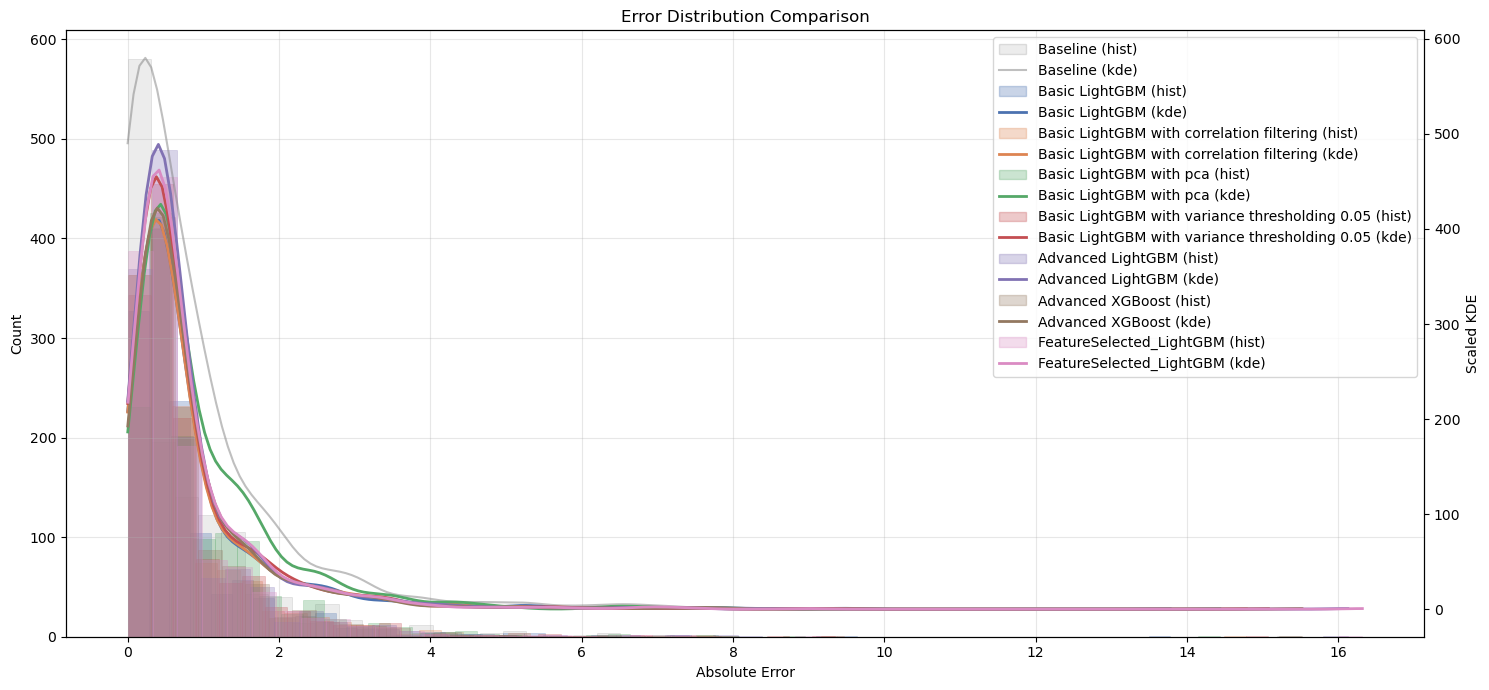


Error Statistics:
                                                Mean Error  Median Error  \
Baseline                                             0.834         0.500   
Basic LightGBM                                       0.833         0.491   
Basic LightGBM with correlation filtering            0.827         0.496   
Basic LightGBM with pca                              0.983         0.599   
Basic LightGBM with variance thresholding 0.05       0.809         0.482   
Advanced LightGBM                                    0.807         0.501   
Advanced XGBoost                                     0.818         0.515   
FeatureSelected_LightGBM                             0.811         0.496   

                                                Std Error  Max Error  \
Baseline                                            1.148     15.500   
Basic LightGBM                                      1.065     13.776   
Basic LightGBM with correlation filtering           1.044     14.783   
Basic Li

In [120]:
def plot_error_distributions_count_kde(trained_models, bins=50):  # increased from 30 to 50 bins
    """
    Plot error distributions with both count histogram and KDE overlay
    with histogram edges and smaller bins
    """
    # Define colors using seaborn color palette
    import seaborn as sns
    model_colors = {}
    
    # Set baseline color to gray
    model_colors['Baseline'] = '#808080'  # gray
    
    # Get other colors from seaborn palette for remaining models
    other_models = [m for m in trained_models.keys() if m != 'Baseline']
    palette = sns.color_palette("deep", n_colors=len(other_models))
    for model, color in zip(other_models, palette):
        model_colors[model] = color
    
    plt.figure(figsize=(15, 7))
    
    # Create twin axes for dual y-axis plotting
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Process baseline first, then other models
    model_order = ['Baseline'] + other_models
    
    for model_name in model_order:
        model = trained_models[model_name]
        try:
            errors = model.val_errors
            color = model_colors[model_name]
            
            # Set opacity based on whether it's baseline or not
            hist_alpha = 0.15 if model_name == 'Baseline' else 0.3
            line_alpha = 0.5 if model_name == 'Baseline' else 1.0
            line_width = 1.5 if model_name == 'Baseline' else 2
            edge_color = '#404040' if model_name == 'Baseline' else color
            
            # Plot histogram with counts on the left y-axis and edges
            ax1.hist(errors, bins=bins, alpha=hist_alpha, color=color,
                    label=f'{model_name} (counts)',
                    edgecolor=edge_color, linewidth=0.5)  # Added edge color and width
            
            # Add KDE on the right y-axis
            kde = gaussian_kde(errors)
            x_range = np.linspace(min(errors), max(errors), 200)
            kde_values = kde(x_range)
            
            # Scale KDE to match histogram height for better visualization
            hist_counts, _ = np.histogram(errors, bins=bins)
            scaling_factor = max(hist_counts) / max(kde_values)
            ax2.plot(x_range, kde_values * scaling_factor, color=color, 
                    alpha=line_alpha, label=f'{model_name} (kde)', 
                    linewidth=line_width)
            
        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            continue
    
    # Set labels and title
    ax1.set_xlabel('Absolute Error')
    ax1.set_ylabel('Count')
    ax2.set_ylabel('Scaled KDE')
    plt.title('Error Distribution Comparison')
    
    # Create a single legend with both histogram and KDE entries
    legend_elements = []
    for model_name in model_order:
        color = model_colors[model_name]
        # Add histogram patch
        legend_elements.append(plt.Rectangle((0,0), 1, 1, fc=color, 
                                          ec=color if model_name != 'Baseline' else '#404040',
                                          alpha=0.15 if model_name == 'Baseline' else 0.3,
                                          label=f'{model_name} (hist)'))
        # Add line
        legend_elements.append(plt.Line2D([0], [0], color=color, 
                                        alpha=0.5 if model_name == 'Baseline' else 1.0,
                                        linewidth=1.5 if model_name == 'Baseline' else 2,
                                        label=f'{model_name} (kde)'))
    
    # Add legend outside the plot
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nError Statistics:")
    stats_df = pd.DataFrame()
    
    for model_name in model_order:
        model = trained_models[model_name]
        try:
            errors = model.val_errors
            stats = {
                'Mean Error': np.mean(errors),
                'Median Error': np.median(errors),
                'Std Error': np.std(errors),
                'Max Error': np.max(errors),
                '90th Percentile': np.percentile(errors, 90),
                '95th Percentile': np.percentile(errors, 95)
            }
            stats_df[model_name] = pd.Series(stats)
        except Exception as e:
            print(f"Error processing statistics for {model_name}: {str(e)}")
            
    print(stats_df.round(3).T)
    
    return stats_df


stats_df = plot_error_distributions_count_kde(trained_models)

In [121]:
stats_df

,Baseline,Basic LightGBM,Basic LightGBM with correlation filtering,Basic LightGBM with pca,Basic LightGBM with variance thresholding 0.05,Advanced LightGBM,Advanced XGBoost,FeatureSelected_LightGBM
Mean Error,0.833954,0.833175,0.827133,0.982727,0.809203,0.807452,0.818020,0.810839
Median Error,0.500000,0.490615,0.495847,0.598776,0.481968,0.501029,0.514803,0.495857
Std Error,1.148171,1.065181,1.043731,1.092785,1.018383,1.029084,0.992484,1.015253
Max Error,15.500000,13.776356,14.782920,14.432540,15.074109,16.123939,15.517995,16.315470
90th Percentile,2.000000,1.826091,1.832434,2.148072,1.792222,1.701483,1.743677,1.720570
95th Percentile,3.000000,2.658862,2.724166,2.857604,2.579566,2.566850,2.509483,2.546937


In [122]:
metrics_df

,Model,Dataset,MAE,RMSE,MSE,R2,Mean Absolute Percentage Error,Mean Prediction,Mean Actual,Max Error,Samples,N Training Features,N Final Features,PCA Components,Selected Features
0,Baseline,Validation,0.8340,1.4191,2.0138,0.1929,26.6880,1.8075,1.8146,15.5000,1343,30,30,N/A,N/A
1,Basic LightGBM,Validation,0.8332,1.3523,1.8288,0.2670,27.2615,1.8145,1.8146,13.7764,1343,30,30,N/A,N/A
2,Basic LightGBM with correlation filtering,Validation,0.8271,1.3317,1.7735,0.2892,27.0085,1.7926,1.8146,14.7829,1343,24,24,N/A,N/A
3,Basic LightGBM with pca,Validation,0.9827,1.4697,2.1599,0.1343,34.5395,1.9403,1.8146,14.4325,1343,13,13,N/A,N/A
4,Basic LightGBM with variance thresholding 0.05,Validation,0.8092,1.3007,1.6919,0.3219,26.4501,1.7743,1.8146,15.0741,1343,18,18,N/A,N/A
5,Advanced LightGBM,Validation,0.8075,1.3080,1.7110,0.3142,25.9872,1.7263,1.8146,16.1239,1343,18,18,N/A,N/A
6,Advanced XGBoost,Validation,0.8180,1.2862,1.6542,0.3370,27.3319,1.8132,1.8146,15.5180,1343,18,18,N/A,N/A
7,FeatureSelected_LightGBM,Validation,0.8108,1.2993,1.6882,0.3234,26.7618,1.7927,1.8146,16.3155,1343,18,18,N/A,N/A


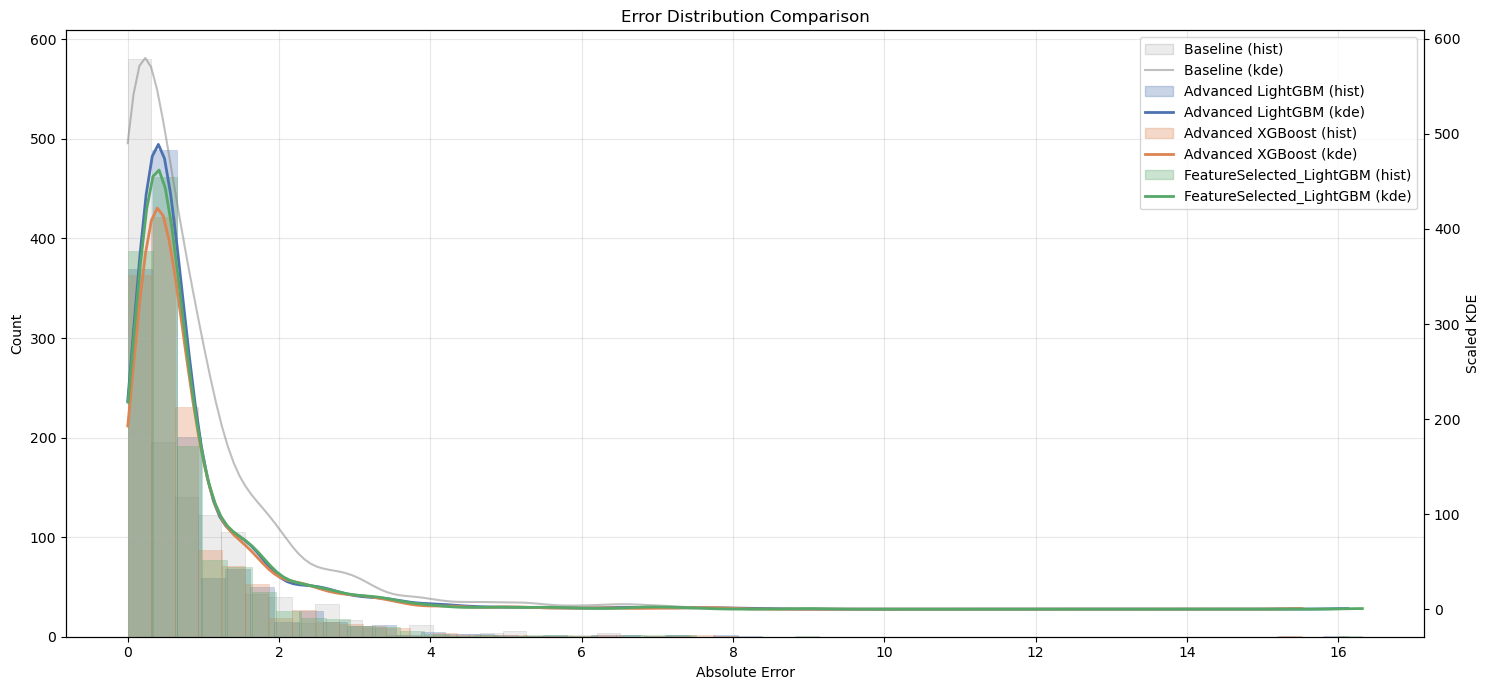


Error Statistics:
                          Mean Error  Median Error  Std Error  Max Error  \
Baseline                       0.834         0.500      1.148     15.500   
Advanced LightGBM              0.807         0.501      1.029     16.124   
Advanced XGBoost               0.818         0.515      0.992     15.518   
FeatureSelected_LightGBM       0.811         0.496      1.015     16.315   

                          90th Percentile  95th Percentile  
Baseline                            2.000            3.000  
Advanced LightGBM                   1.701            2.567  
Advanced XGBoost                    1.744            2.509  
FeatureSelected_LightGBM            1.721            2.547  

Aggregated Model Metrics for Better Models:


,Baseline,Advanced LightGBM,Advanced XGBoost,FeatureSelected_LightGBM
Mean Error,0.833954,0.807452,0.818020,0.810839
Median Error,0.500000,0.501029,0.514803,0.495857
Std Error,1.148171,1.029084,0.992484,1.015253
Max Error,15.500000,16.123939,15.517995,16.315470
90th Percentile,2.000000,1.701483,1.743677,1.720570
95th Percentile,3.000000,2.566850,2.509483,2.546937


In [123]:
better_models = ['Baseline', 'Advanced LightGBM', 'Advanced XGBoost', 'FeatureSelected_LightGBM']
better_model_dict = {model: trained_models[model] for model in better_models}

# Get aggregated metrics for better models
better_metrics_df = plot_error_distributions_count_kde(better_model_dict, bins = 50)
print("\nAggregated Model Metrics for Better Models:")
better_metrics_df


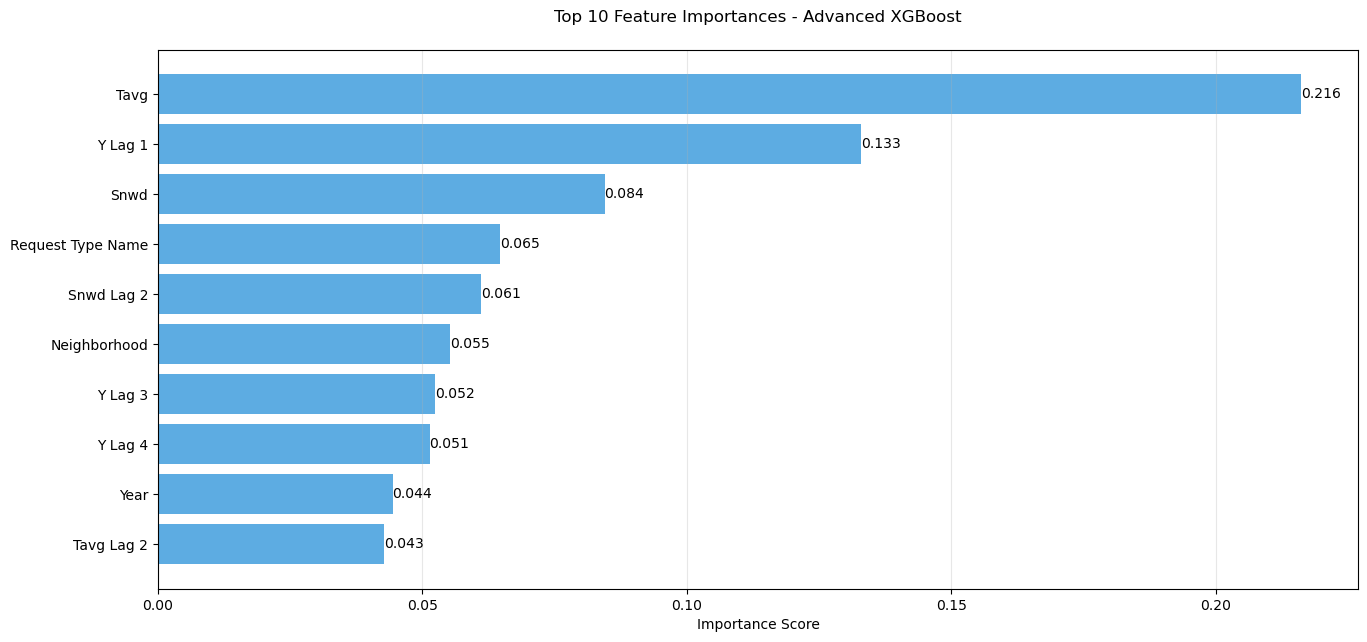


Feature Importance Summary:
Number of features: 18

Top 5 Most Important Features:
Snwd Lag 2: 0.061
Request Type Name: 0.065
Snwd: 0.084
Y Lag 1: 0.133
Tavg: 0.216


In [124]:
def plot_feature_importance(model, top_n=20, figsize=(15, 10)):
    """
    Plot feature importance for a model with clear feature names
    """
    info = model.get_feature_importance_info()
    
    if info is None or 'feature_importances' not in info:
        print("No feature importance information available for this model.")
        return
    
    importances = info['feature_importances']
    
    # Get top N features
    top_features = importances.tail(top_n)  # tail because we sorted ascending
    
    # Create the plot with larger figure size and left margin for labels
    plt.figure(figsize=figsize)
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(top_features)), top_features.values, 
                    color='#3498db', alpha=0.8)
    
    # Customize the plot
    plt.title(f"Top {top_n} Feature Importances - {model.model_name}", pad=20)
    plt.xlabel('Importance Score')
    
    # Set y-axis ticks with feature names
    plt.yticks(range(len(top_features)), 
              top_features.index,  # These are the feature names
              rotation=0,          # Keep text horizontal
              ha='right',         # Right-align the text
              fontsize=10)        # Adjust font size if needed
    
    # Add value labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center', fontsize=10)
    
    # Add grid
    plt.grid(True, axis='x', alpha=0.3)
    
    # Adjust layout to prevent label cutoff
    plt.subplots_adjust(left=0.3)  # Increase left margin for feature names
    
    # Show the plot
    plt.show()
    
    # Print summary statistics
    print("\nFeature Importance Summary:")
    print(f"Number of features: {len(importances)}")
    print(f"\nTop 5 Most Important Features:")
    for name, importance in top_features.tail().items():
        print(f"{name}: {importance:.3f}")

# Example usage:
best_model = trained_models['Advanced XGBoost']
plot_feature_importance(best_model, top_n=10, figsize=(20, 7))

In [183]:
def result(model, week_start, final_df, neighborhood=None, request_type=None, plot_errors=True):
    """
    Get prediction results for a specific week with optional filtering
    
    Parameters:
    -----------
    model : MLPipeline
        Trained model pipeline
    week_start : str or datetime
        The start date of the week to predict
    final_df : pd.DataFrame
        The original dataframe used for training, needed for unique values
    neighborhood : str or list, optional
        Filter by specific neighborhood(s)
    request_type : str or list, optional
        Filter by specific request type(s)
    plot_errors : bool, optional
        Whether to plot error visualizations
    """
    import pandas as pd
    import numpy as np
    import itertools
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_absolute_error
    from sklearn.preprocessing import LabelEncoder
    
    # Convert week_start to datetime if string
    week_start = pd.to_datetime(week_start)

    # Define the data split periods
    training_start = pd.to_datetime('2022-03-28')
    training_end = pd.to_datetime('2024-03-28')
    validation_end = pd.to_datetime('2024-05-28')
    testing_end = pd.to_datetime('2025-02-03')
    
    # Determine which period the week_start falls into
    print("\nDate Information:")
    print(f"Requested prediction date: {week_start.strftime('%Y-%m-%d')}")
    if week_start < training_start:
        print("WARNING: Date is before training period!")
        print(f"Data periods available:")
    elif week_start <= training_end:
        print("This date is in the TRAINING period")
    elif week_start <= validation_end:
        print("This date is in the VALIDATION period")
    elif week_start <= testing_end:
        print("This date is in the TESTING period")
    else:
        print("WARNING: Date is after testing period!")
    
    print(f"\nData Periods:")
    print(f"Training:   {training_start.strftime('%Y-%m-%d')} to {training_end.strftime('%Y-%m-%d')}")
    print(f"Validation: {training_end.strftime('%Y-%m-%d')} to {validation_end.strftime('%Y-%m-%d')}")
    print(f"Testing:    {validation_end.strftime('%Y-%m-%d')} to {testing_end.strftime('%Y-%m-%d')}")
    
    # Get unique neighborhoods and request types from the actual data
    default_neighborhoods = sorted(final_df['neighborhood'].unique())
    default_request_types = sorted(final_df['request_type_name'].unique())
    
    # Use provided filters or defaults
    neighborhoods_to_use = ([neighborhood] if isinstance(neighborhood, str) else neighborhood) if neighborhood is not None else default_neighborhoods
    request_types_to_use = ([request_type] if isinstance(request_type, str) else request_type) if request_type is not None else default_request_types
    
    # Create combinations
    combinations = list(itertools.product([week_start], neighborhoods_to_use, request_types_to_use))
    
    # Create base DataFrame with all combinations
    pred_df = pd.DataFrame(combinations, columns=['week_start', 'neighborhood', 'request_type_name'])
    
    # Create feature matrix X
    X = pred_df.copy()
    
    # Add year
    X['year'] = X['week_start'].dt.year
    
    # Create label encoders and fit them with the training data
    neighborhood_encoder = LabelEncoder()
    request_type_encoder = LabelEncoder()
    
    # Fit encoders with all possible values from training data
    neighborhood_encoder.fit(final_df['neighborhood'])
    request_type_encoder.fit(final_df['request_type_name'])
    
    # Transform categorical variables
    X['neighborhood'] = neighborhood_encoder.transform(X['neighborhood'])
    X['request_type_name'] = request_type_encoder.transform(X['request_type_name'])
    
    # Add all other necessary columns from model.feature_names
    for col in model.feature_names:
        if col not in X.columns:
            if col.startswith('Y_lag'):
                X[col] = 1  # Default value for lag features
            elif col in final_df.columns:
                # Use the mean value from final_df for weather features
                X[col] = final_df[col].mean()
            else:
                X[col] = 0  # Default value for any other features
    
    # Ensure columns match the training features exactly
    X = X[model.feature_names]
    
    # Get predictions
    predictions = model.predict(X)
    
    # Add predictions to results
    results = pred_df[['week_start', 'neighborhood', 'request_type_name']].copy()
    results['predicted_Y'] = predictions
    
    # Add data split information
    results['data_split'] = 'future'
    
    # Convert final_df week_start to datetime if it's not already
    if not isinstance(final_df['week_start'].iloc[0], pd.Timestamp):
        final_df['week_start'] = pd.to_datetime(final_df['week_start'])
    
    
    # Try to get actual values if they exist in the data
    week_data = final_df[final_df['week_start'] == week_start].copy()
    print(f"\nNumber of rows found for {week_start}: {len(week_data)}")
    
    
    
    if not week_data.empty:
        results = results.merge(
            week_data[['neighborhood', 'request_type_name', 'Y']],
            on=['neighborhood', 'request_type_name'],
            how='left'
        )
        
        if 'Y' in results.columns:
            results['absolute_error'] = abs(results['Y'] - results['predicted_Y'])
            
            # Calculate MAE by request type
            mae_by_type = results.groupby('request_type_name').agg({
                'absolute_error': 'mean',
                'Y': 'count'
            }).round(2)
            mae_by_type.columns = ['MAE', 'Sample_Count']
            
            print("\nMAE by Request Type:")
            print(mae_by_type)
            
            if plot_errors:
                plt.figure(figsize=(15, 6))
                mae_by_type_sorted = mae_by_type.sort_values('MAE', ascending=True)
                
                plt.bar(range(len(mae_by_type_sorted)), mae_by_type_sorted['MAE'])
                plt.xticks(range(len(mae_by_type_sorted)), 
                          mae_by_type_sorted.index, 
                          rotation=45, 
                          ha='right')
                plt.title(f'Mean Absolute Error by Request Type\nWeek of {week_start.strftime("%Y-%m-%d")}')
                plt.ylabel('Mean Absolute Error')
                plt.tight_layout()
                plt.show()
    
    # Print summary
    print("\nPrediction Summary:")
    print(f"Week starting: {week_start.strftime('%Y-%m-%d')}")
    print(f"Total predicted requests: {results['predicted_Y'].sum():.0f}")
    
    print("\nPredictions by Request Type:")
    print(results.groupby('request_type_name')['predicted_Y'].sum().round(2))
    
    print("\nPredictions by Neighborhood:")
    print(results.groupby('neighborhood')['predicted_Y'].sum().round(2))
    
    return results


Date Information:
Requested prediction date: 2023-01-02
This date is in the TRAINING period

Data Periods:
Training:   2022-03-28 to 2024-03-28
Validation: 2024-03-28 to 2024-05-28
Testing:    2024-05-28 to 2025-02-03

Number of rows found for 2023-01-02 00:00:00: 99

MAE by Request Type:
                                   MAE  Sample_Count
request_type_name                                   
Angle Iron                         NaN             0
Barricades                        0.31             1
City Steps, Need Cleared          0.08             1
Curb/Request for Asphalt Windrow   NaN             0
Drainage/Leak                     0.36             3
Leaves/Street Cleaning            0.27             3
Litter Can, Public                0.28             9
Litter, Public Property           0.71            32
Overgrowth                         NaN             0
Port A Potty                       NaN             0
Potholes                          1.31            36
Public Right of Way 

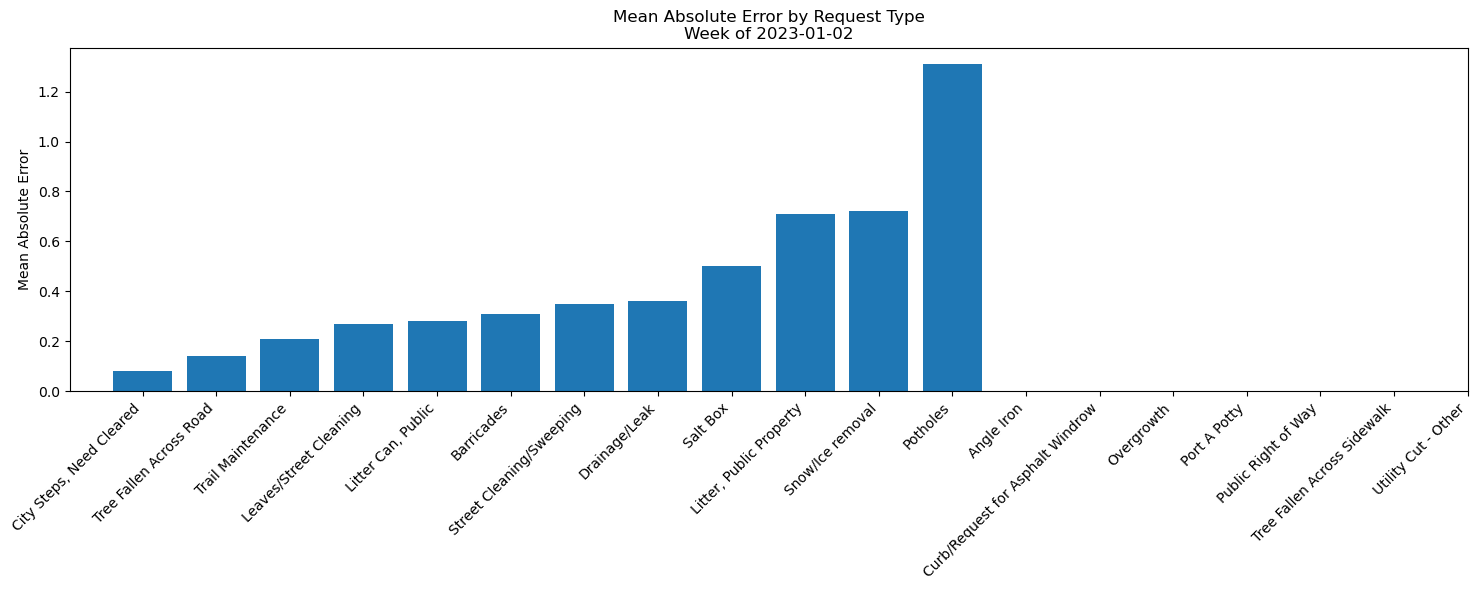


Prediction Summary:
Week starting: 2023-01-02
Total predicted requests: 2029

Predictions by Request Type:
request_type_name
Angle Iron                           97.83
Barricades                           97.83
City Steps, Need Cleared             97.83
Curb/Request for Asphalt Windrow     97.83
Drainage/Leak                        97.83
Leaves/Street Cleaning              103.13
Litter Can, Public                  103.75
Litter, Public Property             113.02
Overgrowth                          114.42
Port A Potty                        114.42
Potholes                            126.00
Public Right of Way                 115.58
Salt Box                            115.58
Snow/Ice removal                    126.47
Street Cleaning/Sweeping            117.57
Trail Maintenance                    98.38
Tree Fallen Across Road              97.42
Tree Fallen Across Sidewalk          96.88
Utility Cut - Other                  96.88
Name: predicted_Y, dtype: float64

Predictions by Neighbo

In [190]:
# Example for a training period date
results = result(better_model_dict['Advanced LightGBM'], '2023-01-02', final_df)
